# `XGBoost` ML training for Cosmic Ray Veto optimisation

## Objective
Optimize the veto condition to maximize cosmic ray purity while minimizing pileup contamination.

**Run tag:** `c`

- Here we use the "best" CRV coincidence per event via central deltaT index
- For CeMix I just take the first coincidence
- We do this so that we can produce efficiency and deadtime metrics which are understandable by the CRV group
- I also use the number of hits / coincidence here
- Also employ other features


## Preprocessing
- Execution: `run/run_ml_prep.py`
- Core logic: `src/core/ml_process.py`

## Training datasets

### Mixed CE (background - label 0)
- `nts.mu2e.CeEndpointMix2BBTriggered.MDC2020aw_best_v1_3_v06_06_00.root`

### Pure CRY (signal - label 1)
- `nts.mu2e.CosmicCRYSignalAllOnSpillTriggered.MDC2020aw_perfect_v1_3_v06_06_00.root`

## Training strategy

Discriminate between:
1. Coincidences from **mixed CE**
2. Coincidences from **pure CRY**

## Implementation 
Discriminate between:
1. Coincidences from **mixed CE**
2. Coincidences from **mixed CRY** (cosmic-produced only, identified via MC truth)

In [3]:
# System tools  
import sys
from pathlib import Path
import warnings
warnings.filterwarnings("ignore") # suppress warnings

# Python stack 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak

# ML tools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve

# Internal modules 
sys.path.extend(["../../../src/core", "../../../src/utils"])
from draw import Draw
from io_manager import Load

# pyutils 
from pyutils.pyplot import Plot
plotter = Plot() # just use this for styles

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1


## Load data

In [4]:
# !mv ../../../output/ml/veto/data/b ../../../output/ml/veto/b # data # veto/b/data
# !mv ../../../output/ml/veto/b/* 
!ls -ltrh ../../../output/ml/veto/d/data

# !ls -ltrh ../../../output/ml/veto/c/data/CRY_onspill-LH_aw/
# ls ../../../output/ml/veto/b ../../../output/ml/veto/b 
# !ls -ltrh ../../../output/ml/veto/b/data/CRY_onspill-LH_aw
# !ls ../../output/ml/cosmic/data/sig/b/results.pkl
# ! ls ../output/ml/data/b/bkg/

total 0
drwxr-sr-x. 2 sgrant 65534 4 Nov 14 22:59 CE_mix_onspill-LH_aw
drwxr-sr-x. 2 sgrant 65534 4 Nov 14 23:01 CRY_onspill-LH_aw


In [5]:
run = "d"
base_in_path = Path(f"../../../output/ml/veto/{run}/data/")
cry_in_path = base_in_path / "CRY_onspill-LH_aw"
ce_mix_in_path = base_in_path/ "CE_mix_onspill-LH_aw"

cry_data = Load(in_path=cry_in_path).load_pkl()
ce_mix_data = Load(in_path=ce_mix_in_path).load_pkl()

[Load] ✅ Initialised with out_path=../../../output/ml/veto/d/data/CRY_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/d/data/CRY_onspill-LH_aw/results.pkl
[Load] ✅ Initialised with out_path=../../../output/ml/veto/d/data/CE_mix_onspill-LH_aw
[Load] ✅ Successfully loaded results from ../../../output/ml/veto/d/data/CE_mix_onspill-LH_aw/results.pkl


## Verify data

In [6]:
display(cry_data["cut_flow"])
display(ce_mix_data["cut_flow"])

,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,2610933,100.000,100.000,No selection applied
1,has_trk_front,Preselect,2558235,97.982,97.982,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,2558229,97.981,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,2478081,94.912,96.867,Electron track fits
4,one_reco_electron,Preselect,2050975,78.553,82.765,One reco electron / event
5,is_downstream,Preselect,1127230,43.173,54.961,Has downstream track (p_z > 0 in tracker)
6,is_truth_electron,Preselect,320790,12.286,28.458,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,253943,9.726,79.162,Track fit quality > 0.2
8,within_t0,Tracker,203324,7.787,80.067,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,188703,7.227,92.809,Track fit t0 uncertainty (t0err < 0.9 ns)


,Cut,Group,Events Passing,Absolute [%],Relative [%],Description
0,No cuts,NaN,1339362,100.000,100.000,No selection applied
1,has_trk_front,Preselect,1336979,99.822,99.822,Tracks intersect tracker entrance
2,has_trk_mid,Preselect,1336978,99.822,100.000,Tracks intersect tracker middle
3,is_reco_electron,Preselect,1327517,99.116,99.292,Electron track fits
4,one_reco_electron,Preselect,1097128,81.914,82.645,One reco electron / event
5,is_downstream,Preselect,1096128,81.840,99.909,Has downstream track (p_z > 0 in tracker)
6,is_truth_electron,Preselect,1096059,81.834,99.994,Track parents are electrons (truth PID)
7,good_trkqual,Tracker,883133,65.937,80.573,Track fit quality > 0.2
8,within_t0,Tracker,655446,48.937,74.218,t0 at tracker mid (640 < t_0 < 1650 ns)
9,within_t0err,Tracker,636329,47.510,97.083,Track fit t0 uncertainty (t0err < 0.9 ns)


[Load] ✅ Initialised with out_path=test_out
[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[Plot] ⭐️ Initialised
CRY
[Plot] ✅ 	Wrote ../../../output/images/ml/veto/d/xgboost/preparation/h1o_3x3_cuts_CRY.png


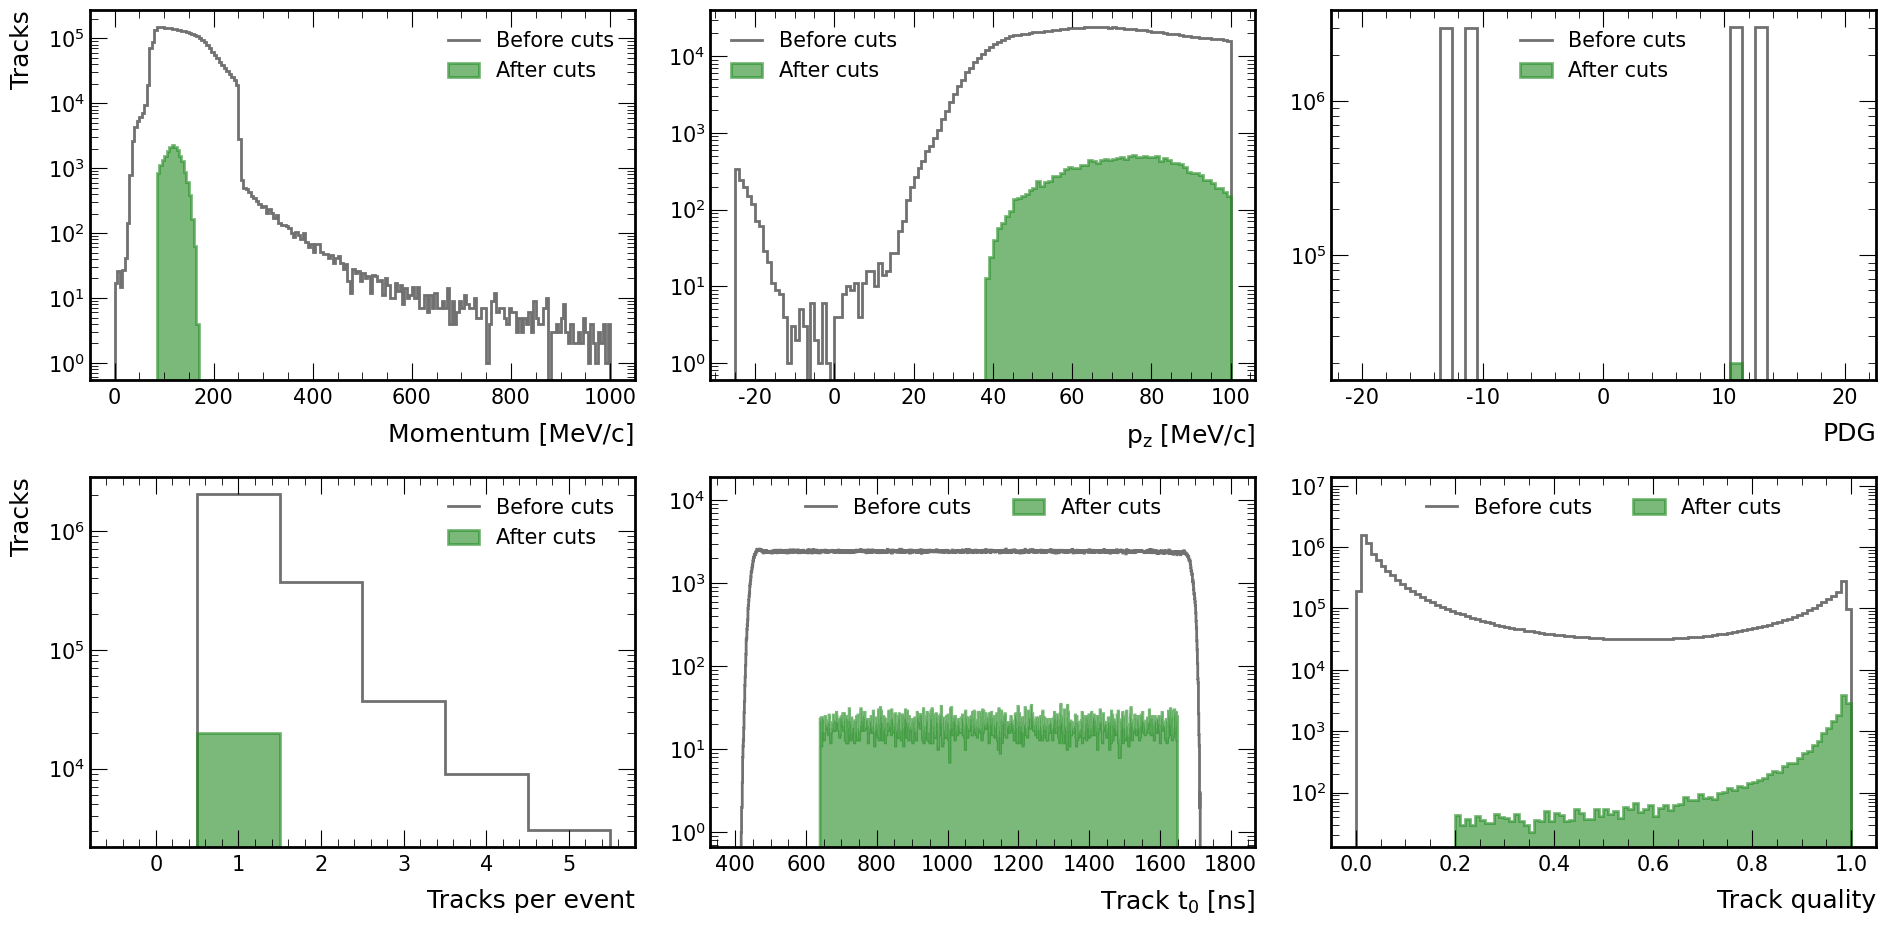

SIGNAL + PILEUP
[Plot] ✅ 	Wrote ../../../output/images/ml/veto/d/xgboost/preparation/h1o_3x3_cuts_CE_mix.png


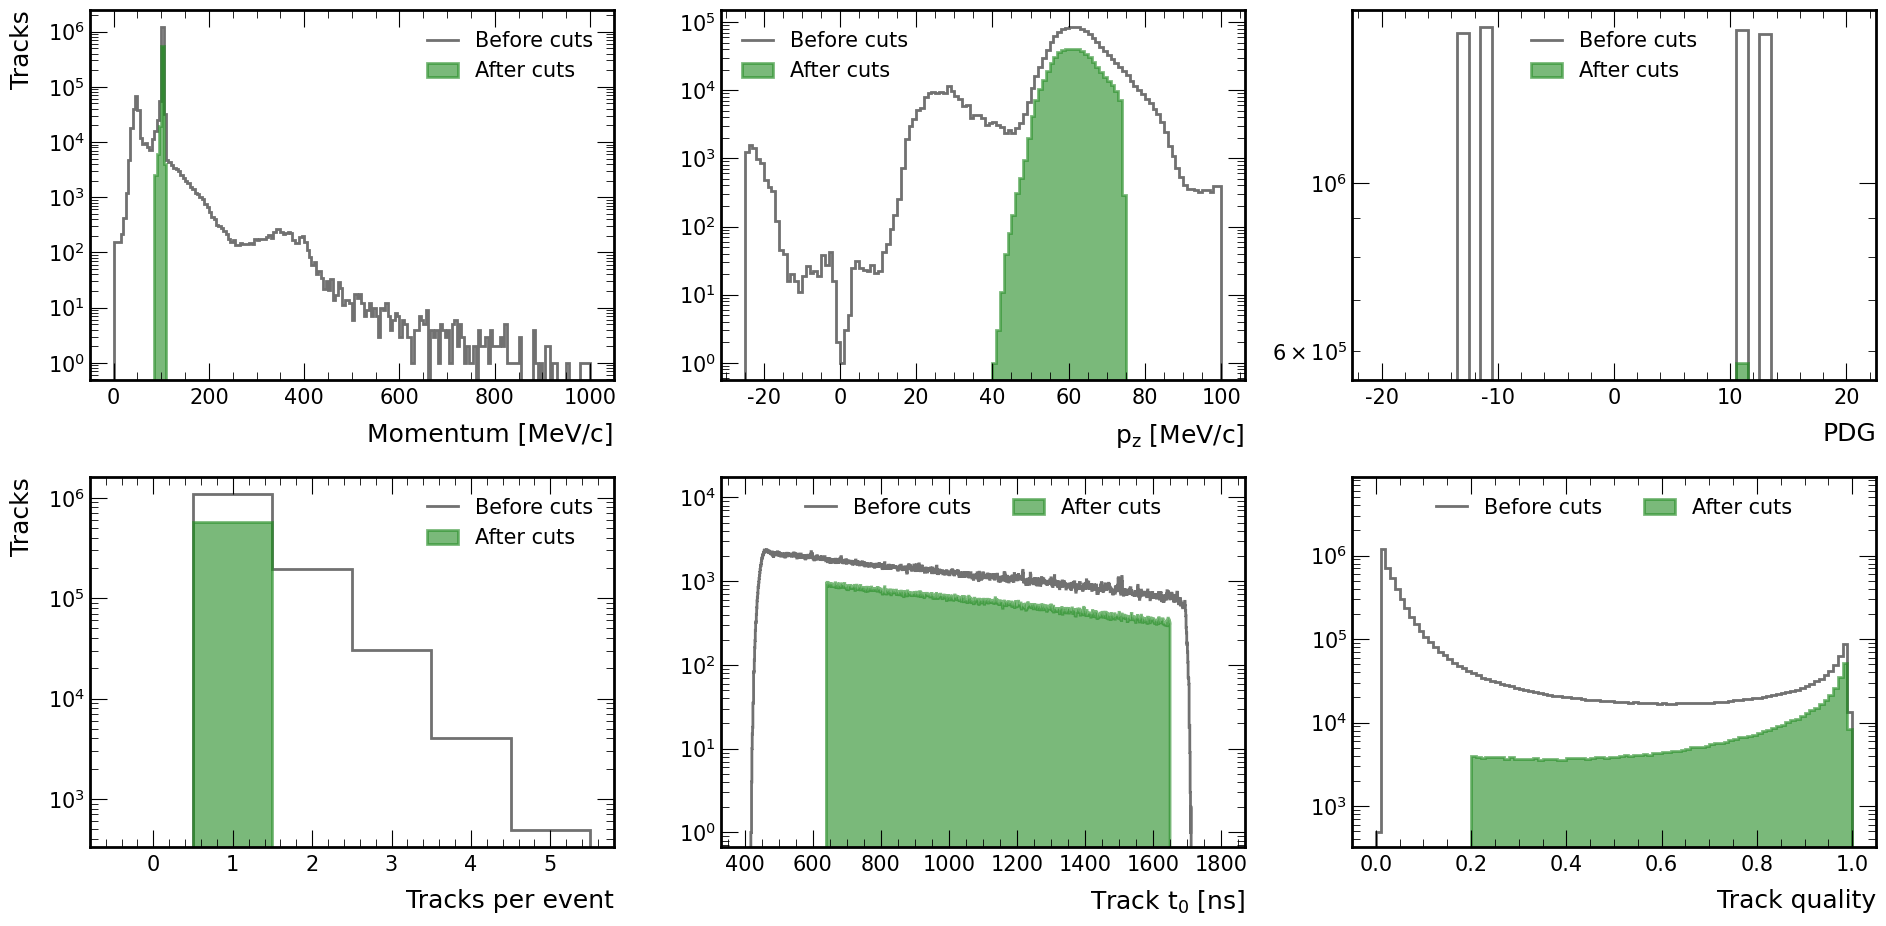

In [7]:
draw = Draw()

img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "preparation"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x2_features.png"

print("CRY")
draw.plot_ml_summary(cry_data["hists"], out_path = img_feature_out_path / "h1o_3x3_cuts_CRY.png")

print("SIGNAL + PILEUP")
draw.plot_ml_summary(ce_mix_data["hists"], out_path = img_feature_out_path / "h1o_3x3_cuts_CE_mix.png")

In [6]:
print(cry_data["events"].type)
print(ce_mix_data["events"].type)

20081 * {event: float64, subrun: float64, crv_z: float32, PEs: float32, dT: float64, nHits: int32, PEs_per_hit: float64, t0: float64, d0: float32, tanDip: float64, maxr: float32, mom_mag: float32}
428440 * {event: float64, subrun: float64, crv_z: float32, PEs: float32, dT: float64, nHits: int32, PEs_per_hit: float64, t0: float64, d0: float32, tanDip: float64, maxr: float32, mom_mag: float32}


In [9]:
from pyutils.pyprint import Print
Print().print_n_events(ce_mix_data["events"], 2)

[pyprint] ⭐️ Initialised Print with verbose = False and precision = 1
[pyprint] ⭐️ Printing 2 event(s)...

-------------------------------------------------------------------------------------
event: 3.0
subrun: 36.0
crv_x: 3946.4208984375
crv_y: 2878.026123046875
crv_z: -9957.7998046875
PEs: 18026.0078125
dT: -10.264850085812327
nHits: 806
nLayers: 4
angle: -0.3155708909034729
PEs_per_hit: 22.364773960918114
t0: 913.8282895626252
d0: 18.65566635131836
tanDip: 0.8123671412467957
maxr: 505.3804626464844
mom_mag: 104.69876098632812
-------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------
event: 18.0
subrun: 36.0
crv_x: 0.0
crv_y: 2727.180908203125
crv_z: -7761.4326171875
PEs: 202.51519775390625
dT: 981.4855756435129
nHits: 5
nLayers: 3
angle: -1.1551920175552368
PEs_per_hit: 40.50303955078125
t0: 1502.8501386317942
d0: 1.3360172510147095
tanDip: 0.7448927164077759
maxr: 539

In [10]:
cry_data["events"]["crv_z"].type.show() # , axis=None)

20081 * float32


## Feature plots

[pyplot] ⭐️ Initialised Plot with mu2e.mplstyle and verbosity = 1
	Wrote ../../../output/images/ml/veto/d/xgboost/features/h1o_2x4_crv_features.png


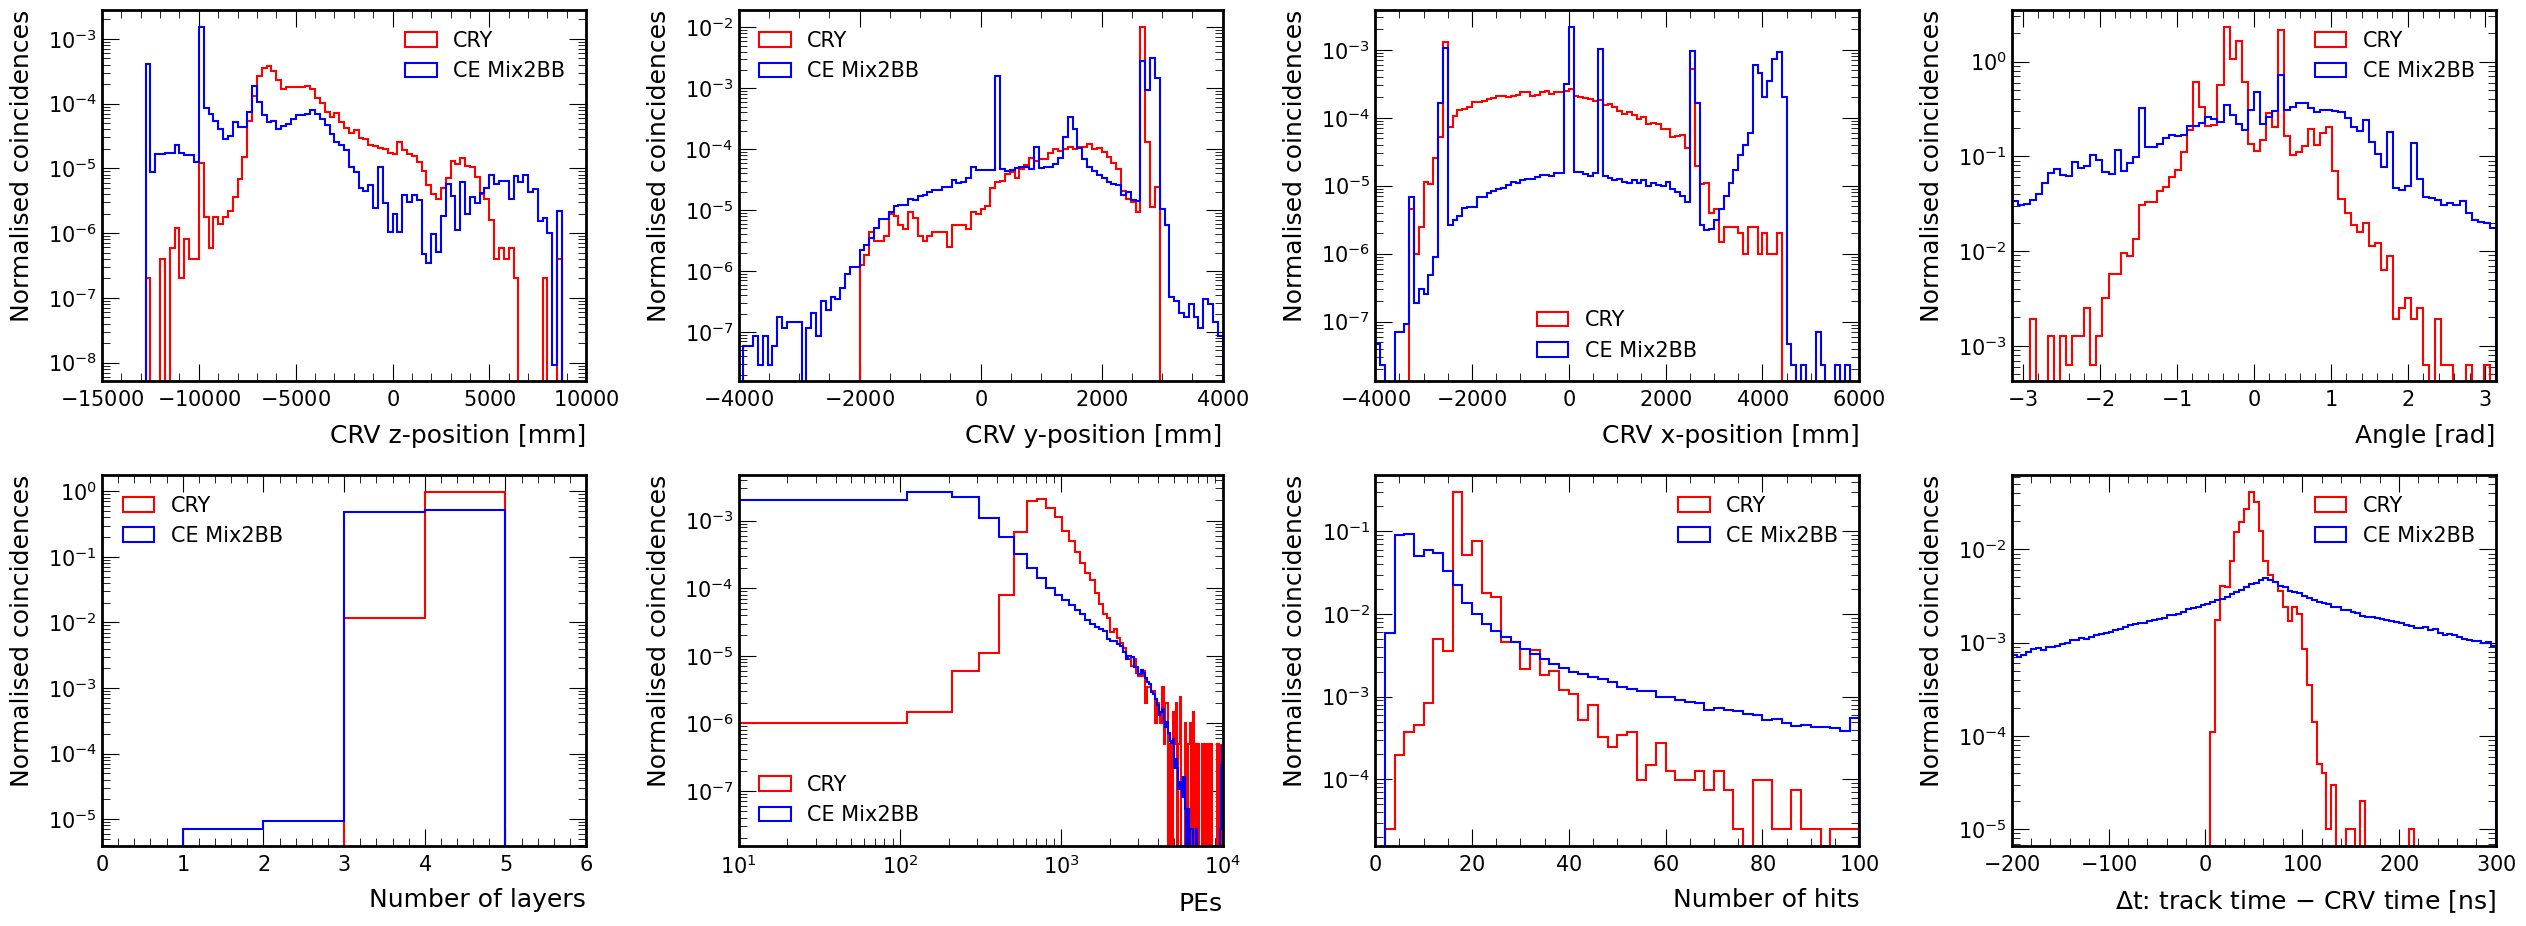

In [15]:
from pyutils.pyplot import Plot 
plotter = Plot()
fig, ax = plt.subplots(2, 4, figsize=(4*6.4, 2*4.8))
styles = {
    "CRY" : { 
        "color" : "red",
    },
    "CE Mix2BB" : {
        "color" : "blue",
    }
}

# Plot 1: CRV z-position - increase bins for smoother distribution
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_z"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["crv_z"], axis=-1),
    },
    nbins=100,  # Reduced from 250 for cleaner look
    xmin=-15000,
    xmax=10000,
    show=False,
    ax=ax[0,0],
    log_y=True,
    xlabel="CRV z-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 2: CRV y-position - focus on main peak region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_y"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["crv_y"], axis=-1),
    },
    nbins=100,  # Reduced from 200
    xmin=-4000,
    xmax=4000,
    show=False,
    ax=ax[0,1],
    log_y=True,
    xlabel="CRV y-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 3: CRV x-position - focus on populated region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["crv_x"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["crv_x"], axis=-1),
    },
    nbins=100,  # Reduced from 200
    xmin=-4000,
    xmax=6000,
    show=False,
    ax=ax[0,2],
    log_y=True,
    xlabel="CRV x-position [mm]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 4: Angle - smoother binning
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["angle"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["angle"], axis=-1),
    },
    nbins=80,  # Reduced from 200 for smoother curves
    xmin=-3.14159,
    xmax=3.14159,  
    show=False,
    ax=ax[0,3],
    log_y=True,
    xlabel="Angle [rad]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 5: Number of layers - discrete values
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["nLayers"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["nLayers"], axis=-1),
    },
    nbins=6,
    xmin=0,
    xmax=6,
    show=False,
    ax=ax[1,0],
    log_y=True,
    xlabel="Number of layers", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 6: CRV PEs - fewer bins for log scale
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["PEs"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["PEs"], axis=-1),
    },
    nbins=100,  # Much fewer bins for log scale
    xmin=10,  # Start at 10 to avoid log(0)
    xmax=1e4,
    show=False,
    ax=ax[1,1],
    log_y=True,
    log_x=True,
    xlabel="PEs", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 7: Number of hits - better resolution in main region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["nHits"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["nHits"], axis=-1),
    },
    nbins=50,  # Reduced from 100
    xmin=0,
    xmax=100,
    show=False,
    ax=ax[1,2],
    log_y=True,
    log_x=False,
    xlabel=r"Number of hits", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

# Plot 8: dT - focus on peak region
plotter.plot_1D_overlay(
    {
        "CRY" : ak.flatten(cry_data["events"]["dT"], axis=-1),
        "CE Mix2BB": ak.flatten(ce_mix_data["events"]["dT"], axis=-1),
    },
    nbins=100,  # Reduced from 250 for cleaner look
    xmin=-200,
    xmax=300,
    show=False,
    ax=ax[1,3],
    log_y=True,
    log_x=False,
    xlabel=r"$\Delta t$: track time $-$ CRV time [ns]", 
    ylabel="Normalised coincidences",
    norm_by_area=True,
    styles=styles
)

plt.tight_layout()
img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_feature_out_path = img_base_path / "features"
img_feature_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h1o_2x4_crv_features.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()

	Wrote ../../../output/images/ml/veto/c/xgboost/features/h2o_dT_vs_z.png


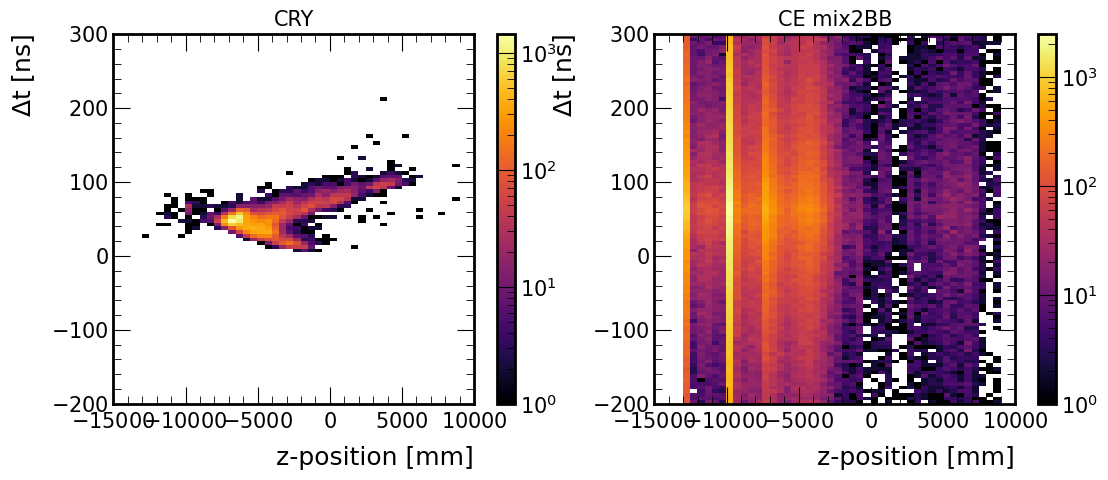

In [10]:
fig, ax = plt.subplots(1,2,figsize=(2*6.4, 4.8))
plotter.plot_2D(
    x = ak.flatten(cry_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(cry_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CRY",
    ax=ax[0]
)
plotter.plot_2D(
    x = ak.flatten(ce_mix_data["events"]["crv_z"], axis=-1),
    y = ak.flatten(ce_mix_data["events"]["dT"], axis=-1),
    nbins_x=50,
    xmin=-15000,
    xmax=10000,
    nbins_y=100,
    ymin=-200,
    ymax=300,
    show=False,
    log_z=True,
    xlabel="z-position [mm]", 
    ylabel=r"$\Delta t$ [ns]", 
    title="CE mix2BB",
    ax=ax[1]
)

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
# model_out_path = Path(f"../../../output/ml/veto/{run}/models/xgboost/features")
# img_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_feature_out_path / "h2o_dT_vs_z.png"

plt.savefig(out_name)
print(f"\tWrote {out_name}")
# plt.show()

In [11]:
# !ls ../../../output/images/ml/veto/a/

## Training 

In [12]:
# Add crv_PEs_per_nHits



In [76]:
# Convert to DataFrame
df_CRY = ak.to_dataframe(cry_data["events"])
df_sig_mix = ak.to_dataframe(ce_mix_data["events"])

# Drop unused columns
col_to_drop = ["event", "subrun", "d0", "tanDip", "maxr", "mom_mag", "PEs_per_hit"] 

df_CRY.drop(columns=col_to_drop, axis=1, inplace=True)
df_sig_mix.drop(columns=col_to_drop, axis=1, inplace=True)

df_CRY["label"] = 1 # "signal"
df_sig_mix["label"] = 0 # "background"

In [77]:
# Combine and shuffle
df_train = pd.concat([df_CRY, df_sig_mix], ignore_index=True)
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
display(df_train)

,crv_z,PEs,dT,nHits,t0,label
0,-9957.799805,413.551697,604.298657,21,1141.929211,0
1,-12576.344727,384.820068,50.178464,15,1407.404904,0
2,-6863.670898,347.883942,64.857832,12,1050.180464,0
3,-12564.646484,15817.377930,-106.582087,949,894.304632,0
4,-9957.799805,15870.406250,22.756350,765,920.464907,0
...,...,...,...,...,...,...
448516,-6815.863770,34.401924,60.079778,3,843.351324,0
448517,-7316.192871,174.955643,408.535386,4,890.721878,0
448518,-7272.661621,160.447296,109.970535,10,1506.499832,0
448519,-11754.934570,207.393555,182.703674,9,795.008789,0


In [78]:
# ==========================================
# SIMPLE dT CUT COMPARISON
# ==========================================
# Apply traditional veto window: -25 < dT < 150 ns
# If dT is in this window, predict it's a cosmic (label 1)

# Get dT values from FULL dataset for sanity check
dT_full = X['dT'].values
y_full = y.values

# Apply simple cut: veto if dT in [-25, 150]
y_pred_dt_cut = ((dT_full >= -25) & (dT_full <= 150)).astype(int)

# Calculate confusion matrix for dT cut
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_full, y_pred_dt_cut)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()

# Calculate metrics for dT cut
veto_efficiency_dt = tp_dt / (tp_dt + fn_dt)
veto_inefficiency_dt = fn_dt / (tp_dt + fn_dt)
deadtime_loss_dt = fp_dt / (tn_dt + fp_dt)
veto_purity_dt = tp_dt / (tp_dt + fp_dt) if (tp_dt + fp_dt) > 0 else 0

# Create comparison DataFrames
print("\n" + "="*80)
print("PERFORMANCE OF SIMPLE dT CUT")
print("="*80)

# Metrics comparison
metrics_comparison_df = pd.DataFrame({
    'Metric': [
        'Veto efficiency',
        'Deadtime',
        'Figure of merit'
    ],
    'dT Cut': [
        f"{veto_efficiency_dt*100:.2f}%",
        f"{deadtime_loss_dt*100:.2f}%",
        f"{veto_efficiency_dt * (1 - deadtime_loss_dt):.4f}"
    ],
})

# Confusion matrix comparison
confusion_comparison_df = pd.DataFrame({
    'Category': [
        'True Positives (CRY vetoed)',
        'True Negatives (CE mix passed)',
        'False Positives (CE mix vetoed)',
        'False Negatives (CRY leaked)',
    ],
    'dT Cut': [
        tp_dt, 
        tn_dt, 
        fp_dt, 
        fn_dt,
    ],
})

print("\n📊 Performance Metrics:")
display(metrics_comparison_df)

print("\n📈 Confusion Matrix Counts:")
display(confusion_comparison_df)


PERFORMANCE OF SIMPLE dT CUT

📊 Performance Metrics:


,Metric,dT Cut
0,Veto efficiency,99.98%
1,Deadtime,41.81%
2,Figure of merit,0.5818



📈 Confusion Matrix Counts:


,Category,dT Cut
0,True Positives (CRY vetoed),20077
1,True Negatives (CE mix passed),249296
2,False Positives (CE mix vetoed),179144
3,False Negatives (CRY leaked),4


In [79]:
X = df_train.drop("label", axis=1)
y = df_train["label"]

# Define feature names from actual columns
feature_names = list(X.columns)
print(f"Features: {feature_names}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining: {len(X_train)} events")
print(f"Test: {len(X_test)} events")

Features: ['crv_z', 'PEs', 'dT', 'nHits', 't0']

Training: 358816 events
Test: 89705 events


In [80]:
# Actually not really needed for BDTs

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled")

✅ Features scaled


In [81]:
print("\n🚀 Training XGBoost model...")

model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model.fit(X_train_scaled, y_train)

# Assign feature names for plotting / saving
model.get_booster().feature_names = feature_names

print("✅ Training complete!")


🚀 Training XGBoost model...
✅ Training complete!


## Store model

In [82]:
!pwd

/home/sgrant/mu2e-cosmic/notebooks/ml/veto


In [83]:
# model_out_path = Path(f"../../../output/ml/veto/models/{run}")
model_out_path = Path(f"../../../output/ml/veto/{run}/models")
model_out_path.mkdir(parents=True, exist_ok=True)


# Full path to model file
model_file_path = model_out_path / "trained_xgboost.json"

# Save the model
model.save_model(str(model_file_path))  # XGBoost often needs string path
print(f"\n✅ Done! Model saved to {model_file_path}")


✅ Done! Model saved to ../../../output/ml/veto/c/models/trained_xgboost.json


## Analyse model 

In [84]:
feature_names = model.get_booster().feature_names


⭐️ Feature importance:
  crv_z     : 0.5042
  PEs       : 0.3658
  dT        : 0.0603
  nHits     : 0.0654
  t0        : 0.0043
	Wrote ../../../output/images/ml/veto/c/xgboost/validation/bar_feature_importance.png


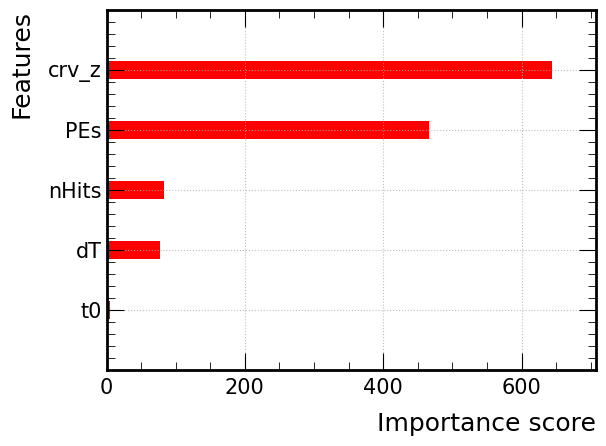

In [85]:
print("\n⭐️ Feature importance:") 
for feat, imp in zip(feature_names, model.feature_importances_):
    print(f"  {feat:10s}: {imp:.4f}") 

xgb.plot_importance(model, importance_type='gain', show_values=False, height=0.3)
plt.title("")
plt.tight_layout()

# img_base_path = Path(f"../../../output/images/ml/veto/{run}/xgboost")
img_validation_out_path = img_base_path / "validation"
img_validation_out_path.mkdir(exist_ok=True, parents=True)
out_name = img_validation_out_path / "bar_feature_importance.png"
plt.savefig(out_name)

print(f"\tWrote {out_name}")
# out_name = img_out_path / "bar_feature_importance.png" 
# plt.savefig(out_name)
plt.show()

In [86]:
train_pred = model.predict_proba(X_train_scaled)[:, 1]
test_pred = model.predict_proba(X_test_scaled)[:, 1]

train_auc = roc_auc_score(y_train, train_pred)
test_auc = roc_auc_score(y_test, test_pred)

print(f"\nTraining AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")


Training AUC: 0.9999
Test AUC: 0.9999


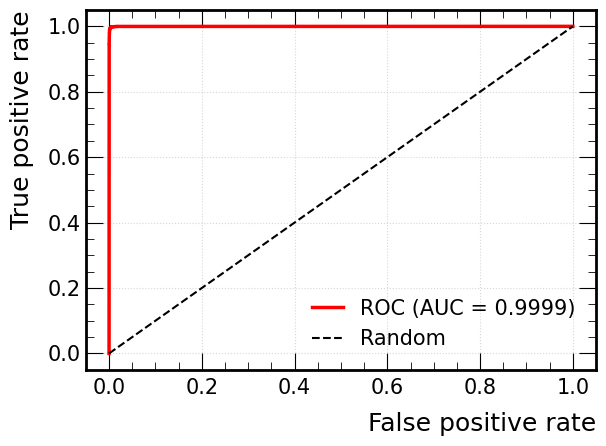


✅ Done! ROC curve saved to ../../../output/images/ml/veto/c/xgboost/validation/roc_curve.png


In [87]:
fpr, tpr, _ = roc_curve(y_test, test_pred)

plt.figure()
plt.plot(fpr, tpr, linewidth=2.5, label=f'ROC (AUC = {test_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")
# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(0.0, 0.2)
# plt.ylim(0.9999, 1)
plt.grid(alpha=0.5)
plt.tight_layout()

out_name = img_validation_out_path /  "roc_curve.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! ROC curve saved to {out_name}")

In [88]:
# Are there duplicate events?
print(f"Train events: {len(X_train)}")
print(f"Test events: {len(X_test)}")
print(f"Overlap: {len(set(X_train.index) & set(X_test.index))}")
print(feature_names)

Train events: 358816
Test events: 89705
Overlap: 0
['crv_z', 'PEs', 'dT', 'nHits', 't0']


In [89]:
print(img_validation_out_path)

../../../output/images/ml/veto/c/xgboost/validation


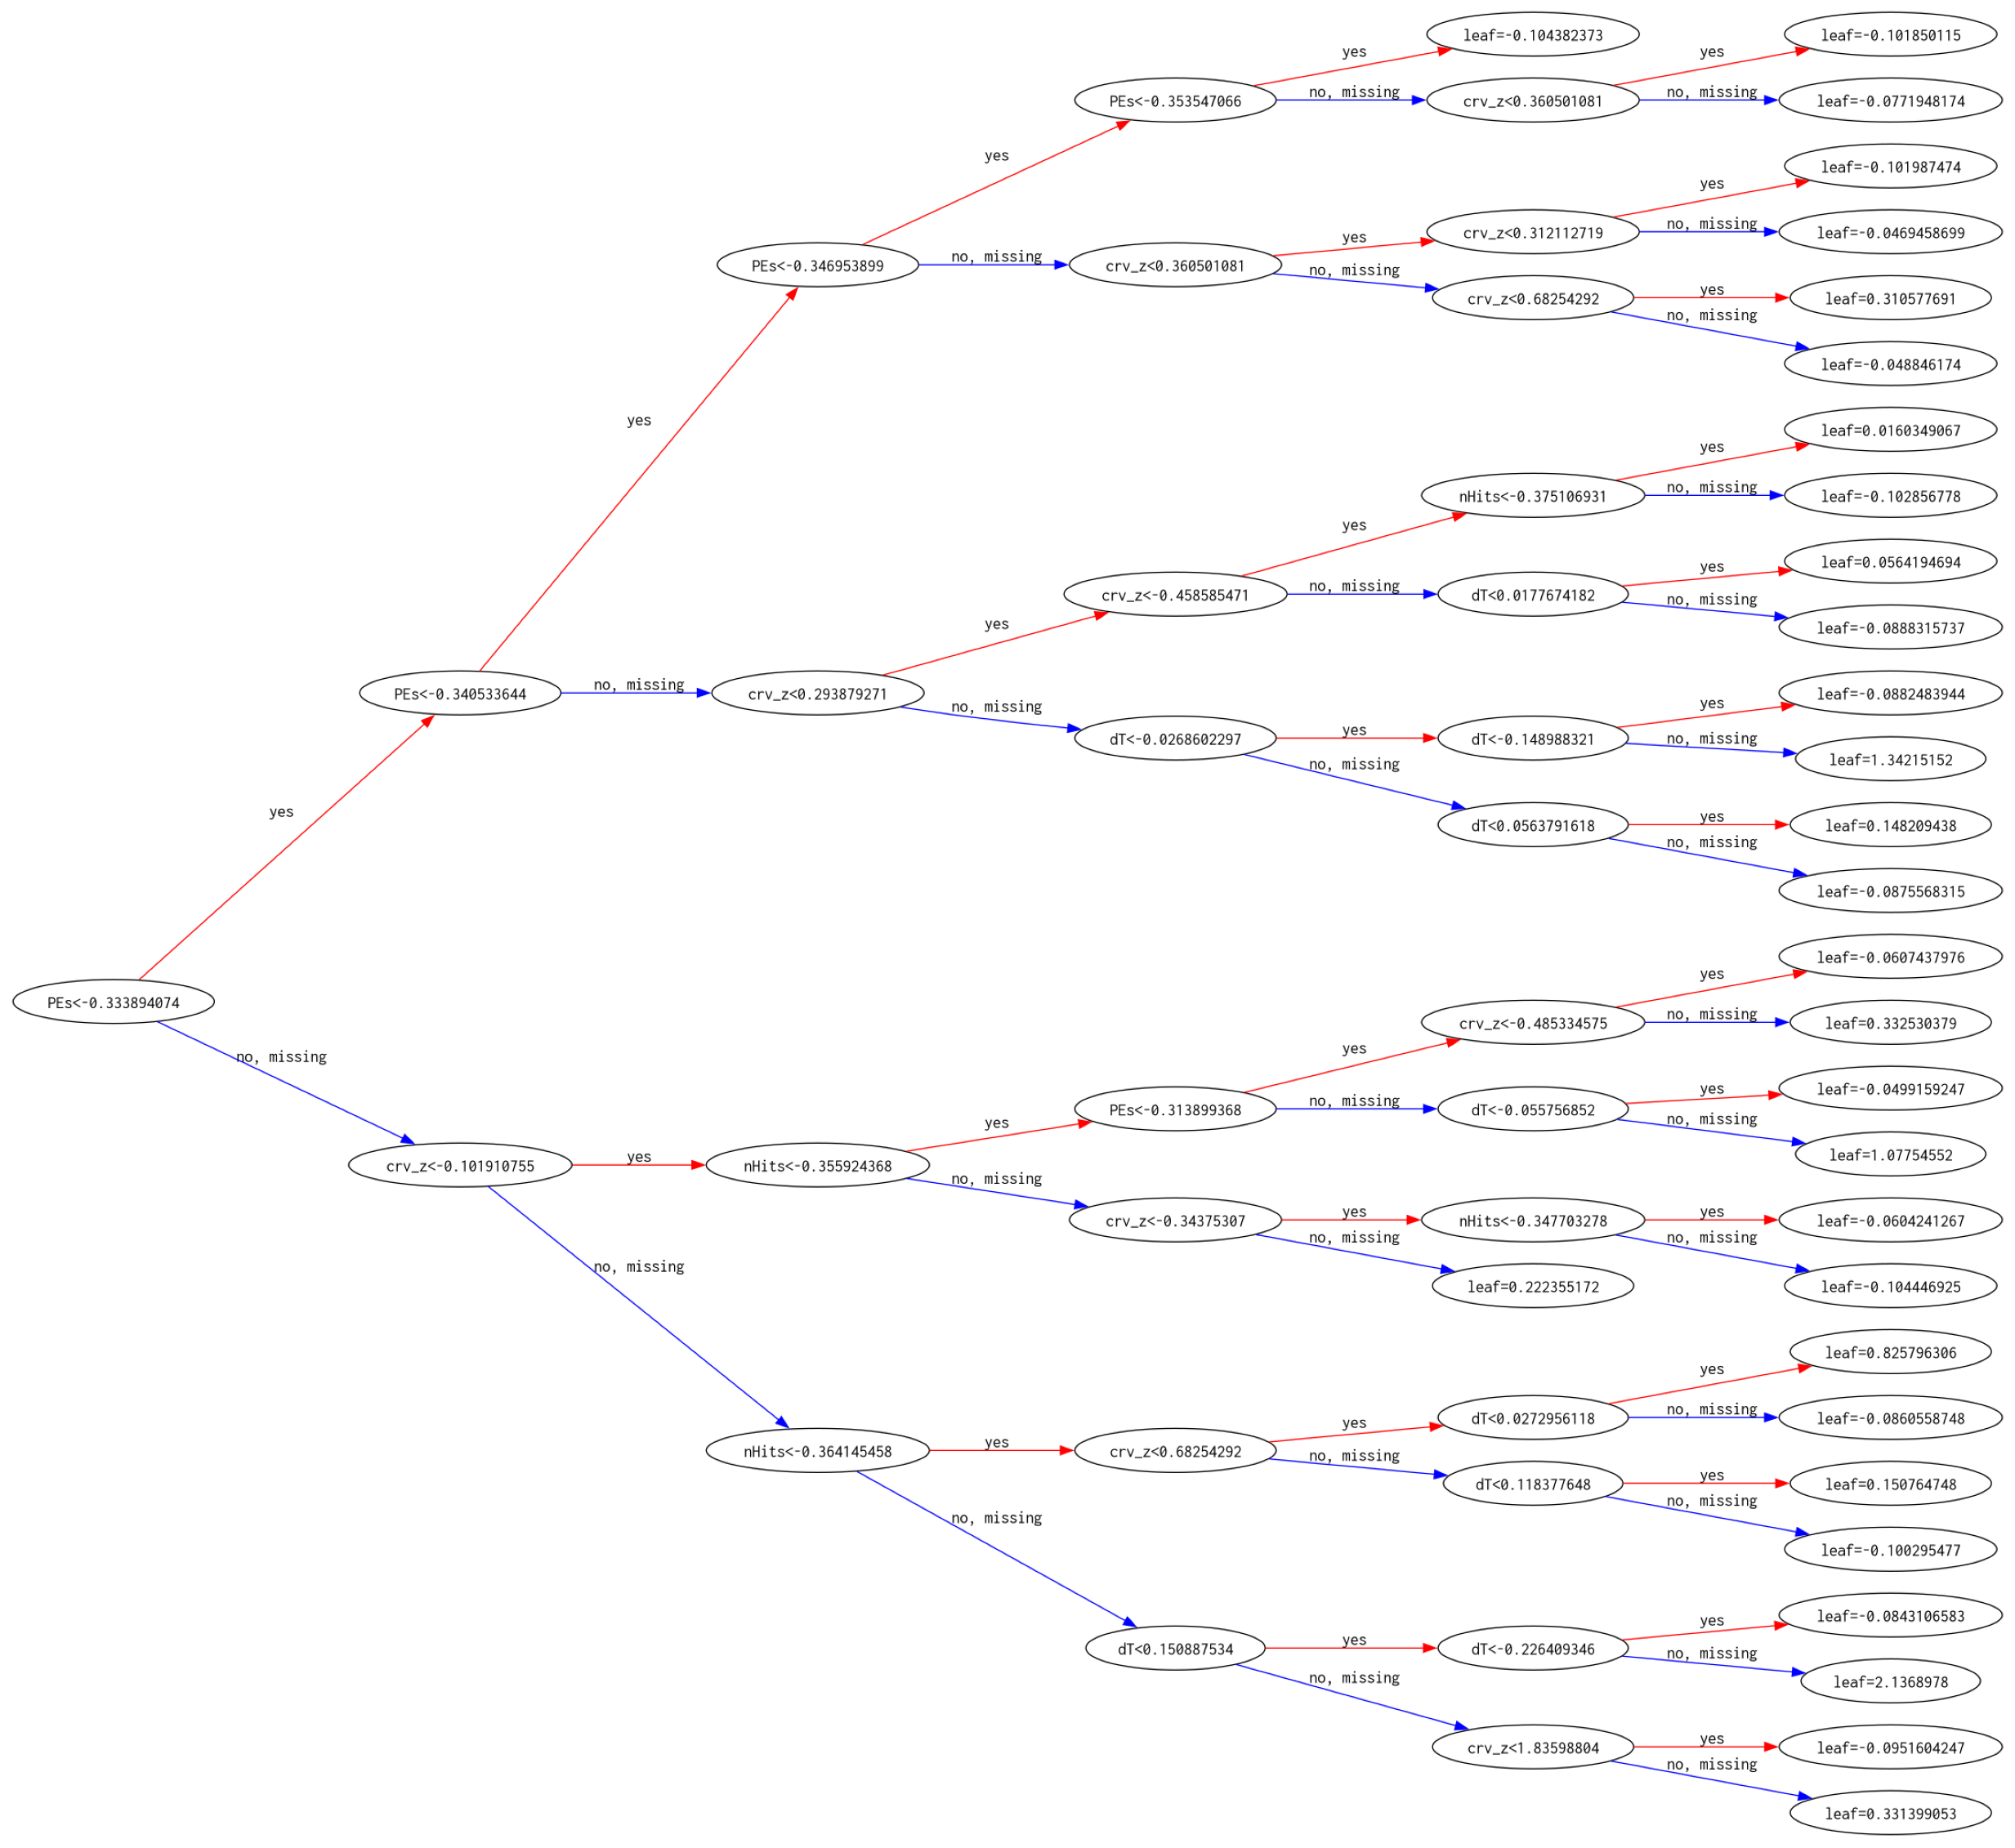


✅ Done! Tree saved to ../../../output/images/ml/veto/c/xgboost/validation/tree_mix.png


In [90]:
fig, ax = plt.subplots(figsize=(25, 25))
xgb.plot_tree(model, num_trees=0, rankdir="LR", ax=ax)
plt.tight_layout()

out_name = img_validation_out_path / "tree_mix.png"
plt.savefig(out_name)
plt.show()

print(f"\n✅ Done! Tree saved to {out_name}")

## Model output histogram 

	Wrote ../../../output/images/ml/veto/c/xgboost/validation/model_output.png


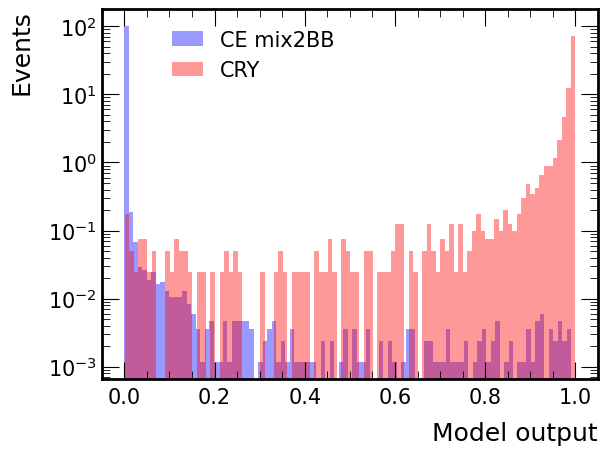

In [91]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB

# Plot score distributions
plt.figure() 

plt.hist(background_scores, bins=100, alpha=0.4, label='CE mix2BB',
         density=True, color='blue')
plt.hist(signal_scores, bins=100, alpha=0.4, label='CRY',
         density=True, color='red')

plt.xlabel('Model output')
plt.ylabel('Events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
out_name = img_validation_out_path / "model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()


## Threshold optimisation 


Threshold optimisation results




,Strategy,Threshold,Veto efficiency,Deadtime,Figure of merit
0,Signal significance,0.419,98.78%,0.10%,0.9868
1,Efficiency >= 99.9%,0.001,99.98%,1.77%,0.9821
2,Balanced FOM,0.033,99.75%,0.36%,0.9939



✅ Threshold optimisation plot saved to ../../../output/images/ml/veto/c/xgboost/validation/threshold_optimisation.png


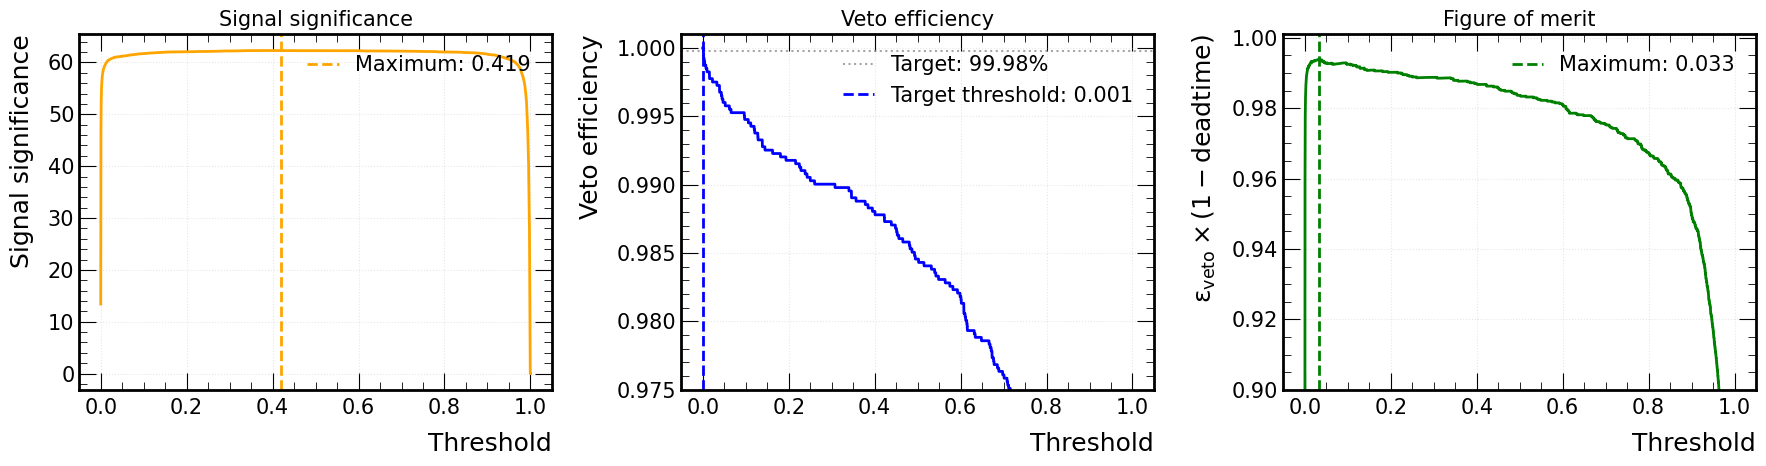

In [264]:
thresholds = np.linspace(0, 1, 10000)

# Calculate all metrics in a single loop
veto_efficiencies = []
deadtime_losses = []
significance_values = []

for thr in thresholds:
    y_pred_label = (test_pred > thr).astype(int)
    
    # Calculate confusion matrix elements
    tp = ((y_test == 1) & (y_pred_label == 1)).sum()
    fn = ((y_test == 1) & (y_pred_label == 0)).sum()
    fp = ((y_test == 0) & (y_pred_label == 1)).sum()
    tn = ((y_test == 0) & (y_pred_label == 0)).sum()
    
    # Veto efficiency and deadtime
    veto_eff = tp / (tp + fn) if (tp + fn) > 0 else 0
    deadtime = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    veto_efficiencies.append(veto_eff)
    deadtime_losses.append(deadtime)
    
    # Signal significance (S/root(S+B))
    significance = tp / np.sqrt(tp + fp) if (tp + fp) > 0 else 0
    significance_values.append(significance)

# Convert to numpy arrays for easier manipulation
veto_efficiencies = np.array(veto_efficiencies)
deadtime_losses = np.array(deadtime_losses)
significance_values = np.array(significance_values)

# Strategy 1: Signal significance (S/root(S+B))
optimal_idx_significance = np.argmax(significance_values)
optimal_threshold_significance = thresholds[optimal_idx_significance]
# Metrics 
eff_significance = veto_efficiencies[optimal_idx_significance]
dt_significance = deadtime_losses[optimal_idx_significance]
max_significance = significance_values[optimal_idx_significance]

# Strategy 2: Target 99.9% efficiency 
target_efficiency = 0.9998
optimal_idx_eff = np.argmin(np.abs(veto_efficiencies - target_efficiency))
optimal_threshold_eff = thresholds[optimal_idx_eff]
# Metrics
eff_eff = veto_efficiencies[optimal_idx_eff]
dt_eff = deadtime_losses[optimal_idx_eff]

# Strategy 3: Balanced figure of merit (efficiency times (1 - deadtime))
figure_of_merit = veto_efficiencies * (1 - deadtime_losses)
optimal_idx_fom = np.argmax(figure_of_merit)
optimal_threshold_fom = thresholds[optimal_idx_fom]
# Metrics 
eff_fom = veto_efficiencies[optimal_idx_fom]
dt_fom = deadtime_losses[optimal_idx_fom]
fom_fom = figure_of_merit[optimal_idx_fom]

# Create comparison DataFrame
print("\n" + "="*80)
print("Threshold optimisation results")
print("="*80)

threshold_comparison_df = pd.DataFrame({
    'Strategy': [
        'Signal significance',
        'Efficiency >= 99.9%', 
        'Balanced FOM',
    ],
    'Threshold': [
        f"{optimal_threshold_significance:.3f}",
        f"{optimal_threshold_eff:.3f}",
        f"{optimal_threshold_fom:.3f}"
    ],
    'Veto efficiency': [
        f"{eff_significance*100:.2f}%",
        f"{eff_eff*100:.2f}%",
        f"{eff_fom*100:.2f}%"
    ],
    'Deadtime': [
        f"{dt_significance*100:.2f}%",
        f"{dt_eff*100:.2f}%",
        f"{dt_fom*100:.2f}%"
    ],
    'Figure of merit': [
        f"{eff_significance * (1 - dt_significance):.4f}",
        f"{eff_eff * (1 - dt_eff):.4f}",
        f"{fom_fom:.4f}"
    ]
})

print("\n")
display(threshold_comparison_df)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Left: Signal significance
axes[0].plot(thresholds, significance_values, linewidth=2, color='orange')
axes[0].axvline(optimal_threshold_significance, color='orange', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_threshold_significance:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Signal significance')
axes[0].set_title('Signal significance')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Middle: Veto efficiency vs threshold
axes[1].plot(thresholds, veto_efficiencies, linewidth=2, color='blue')
axes[1].axhline(target_efficiency, color='grey', linestyle=':', linewidth=1.5, alpha=0.7,
                label=f'Target: {target_efficiency*100:.2f}%')
axes[1].axvline(optimal_threshold_eff, color='blue', linestyle='--', linewidth=2, 
                label=f'Target threshold: {optimal_threshold_eff:.3f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Veto efficiency')
axes[1].set_title('Veto efficiency')
axes[1].set_ylim([0.975, 1.001])
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

# Right: Balanced figure of merit
axes[2].plot(thresholds, figure_of_merit, linewidth=2, color='green')
axes[2].axvline(optimal_threshold_fom, color='green', linestyle='--', linewidth=2,
                label=f'Maximum: {optimal_threshold_fom:.3f}')
axes[2].set_xlabel('Threshold')
axes[2].set_ylabel(r'$\epsilon_{\text{veto}}\times(1-\text{deadtime})$')
axes[2].set_title('Figure of merit')
axes[2].set_ylim([0.9, 1.001])
axes[2].legend(loc='upper right')
axes[2].grid(alpha=0.3)

plt.tight_layout()

out_name = img_validation_out_path / "threshold_optimisation.png"
plt.savefig(out_name)
print(f"\n✅ Threshold optimisation plot saved to {out_name}")

plt.show()

In [266]:
optimal_threshold_eff

0.0014001400140014


✅ Metrics overlay plot saved to ../../../output/images/ml/veto/c/xgboost/validation/threshold_metrics_overlay.png


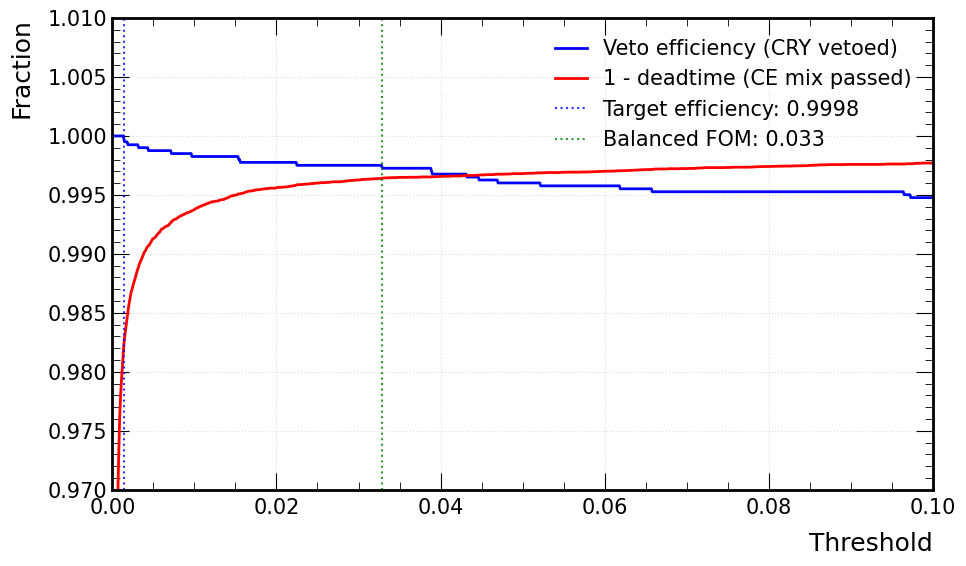

In [297]:
# Create overlay plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(thresholds, veto_efficiencies, linewidth=2, color='blue', label='Veto efficiency (CRY vetoed)')
ax.plot(thresholds, 1 - deadtime_losses, linewidth=2, color='red', label='1 - deadtime (CE mix passed)')

# Add vertical lines for your three strategies
ax.axvline(optimal_threshold_eff, color='blue', linestyle=':', alpha=0.8,
           label=f'Target efficiency: {target_efficiency:.4f}')
ax.axvline(optimal_threshold_fom, color='green', linestyle=':', alpha=0.8,
           label=f'Balanced FOM: {optimal_threshold_fom:.3f}')
# ax.axvline(optimal_threshold_significance, color='orange', linestyle=':', alpha=0.8, 
#            label=f'Signal significance: {optimal_threshold_significance:.3f}')

ax.set_xlabel('Threshold')
ax.set_ylabel('Fraction')
# ax.set_title('Performance vs threshold')
ax.set_ylim([0.97, 1.01])
ax.set_xlim([0, 0.1])
ax.legend(loc='best') # , frameon=True)
ax.grid(alpha=0.4)

plt.tight_layout()

out_name = img_validation_out_path / "threshold_metrics_overlay.png"
plt.savefig(out_name)
print(f"\n✅ Metrics overlay plot saved to {out_name}")

plt.show()

In [232]:
# # Calculate signal efficiency (fraction of CE mix events that pass)
# signal_efficiencies = []
# for thr in thresholds:
#     y_pred_label = (test_pred > thr).astype(int)
#     tn = ((y_test == 0) & (y_pred_label == 0)).sum()
#     fp = ((y_test == 0) & (y_pred_label == 1)).sum()
#     signal_eff = tn / (tn + fp) if (tn + fp) > 0 else 0
#     signal_efficiencies.append(signal_eff)

# signal_efficiencies = np.array(signal_efficiencies)

# # Create overlay plot
# fig, ax = plt.subplots(figsize=(10, 6))

# ax.plot(thresholds, veto_efficiencies, linewidth=2, color='blue', label='Veto efficiency (CRY vetoed)')
# ax.plot(thresholds, signal_efficiencies, linewidth=2, color='orange', label='Signal efficiency (CE mix passed)')
# # ax.plot(thresholds, deadtime_losses, linewidth=2, color='orange', label='Deadtime (CE mix vetoed)')

# # Add vertical lines for your three strategies

# ax.axvline(optimal_threshold_eff, color='blue', linestyle=':', alpha=0.5,
#            label=f'Target efficiency: {optimal_threshold_eff:.3f}')
# ax.axvline(optimal_threshold_fom, color='green', linestyle=':', alpha=0.5,
#            label=f'Balanced FOM: {optimal_threshold_fom:.3f}')
# ax.axvline(optimal_threshold_significance, color='red', linestyle=':', alpha=0.5, 
#            label=f'Signal significance: {optimal_threshold_significance:.3f}')

# ax.set_xlabel('Threshold')
# ax.set_ylabel('Fraction')
# ax.set_title('Performance vs threshold')
# ax.set_yscale('log') # [0, 1.05])
# ax.set_ylim([0.9, 1.05])
# # ax.set_xlim([0, 0.5])
# ax.legend(loc='best', frameon=True)
# ax.grid(alpha=0.3)

# plt.tight_layout()

# out_name = img_validation_out_path / "threshold_metrics_overlay.png"
# plt.savefig(out_name)
# print(f"\n✅ Metrics overlay plot saved to {out_name}")

# plt.show()

In [146]:


# # ==========================================
# # THRESHOLD OPTIMISATION STRATEGIES
# # ==========================================

# thresholds = np.linspace(0, 1, 1000)

# # Calculate efficiency and deadtime for all thresholds
# veto_efficiencies = []
# deadtime_losses = []
# for thr in thresholds:
#     y_pred_label = (test_pred > thr).astype(int)
#     tp = ((y_test == 1) & (y_pred_label == 1)).sum()
#     fn = ((y_test == 1) & (y_pred_label == 0)).sum()
#     fp = ((y_test == 0) & (y_pred_label == 1)).sum()
#     tn = ((y_test == 0) & (y_pred_label == 0)).sum()
    
#     veto_eff = tp / (tp + fn) if (tp + fn) > 0 else 0
#     deadtime = fp / (fp + tn) if (fp + tn) > 0 else 0
    
#     veto_efficiencies.append(veto_eff)
#     deadtime_losses.append(deadtime)

# # Strategy 1: Balanced figure of merit
# # Use a figure of merit: efficiency × (1 - deadtime)
# # This rewards high efficiency but penalises high deadtime
# figure_of_merit = [eff * (1 - dt) for eff, dt in zip(veto_efficiencies, deadtime_losses)]
# optimal_idx_balanced = np.argmax(figure_of_merit)
# optimal_threshold_balanced = thresholds[optimal_idx_balanced]
# eff_balanced = veto_efficiencies[optimal_idx_balanced]
# dt_balanced = deadtime_losses[optimal_idx_balanced]
# fom_balanced = figure_of_merit[optimal_idx_balanced]

# # Strategy 2: Signal significance (S/√(S+B))
# # Traditional particle physics metric
# significance_values = []
# for thr in thresholds:
#     y_pred_label = (test_pred > thr).astype(int)
#     S = ((y_test == 1) & (y_pred_label == 1)).sum()  # True positives
#     B = ((y_test == 0) & (y_pred_label == 1)).sum()  # False positives
#     if S + B > 0:
#         significance_values.append(S / np.sqrt(S + B))
#     else:
#         significance_values.append(0)

# optimal_idx_significance = np.argmax(significance_values)
# optimal_threshold_significance = thresholds[optimal_idx_significance]
# eff_significance = veto_efficiencies[optimal_idx_significance]
# dt_significance = deadtime_losses[optimal_idx_significance]
# max_significance = significance_values[optimal_idx_significance]

# # Strategy 3: Target 99.98% efficiency with minimum deadtime
# # Find the highest threshold that still achieves >= 99.98% efficiency
# target_efficiency = 0.9998

# valid_indices = [i for i, eff in enumerate(veto_efficiencies) if eff >= target_efficiency]

# if valid_indices:
#     # Pick the highest threshold (most permissive) that still hits target
#     # Higher threshold = fewer vetoes = lower deadtime
#     optimal_threshold_target = thresholds[max(valid_indices)]
#     optimal_idx_target = max(valid_indices)
#     eff_target = veto_efficiencies[optimal_idx_target]
#     dt_target = deadtime_losses[optimal_idx_target]
#     target_achievable = True
# else:
#     # If 99.9% not achievable, fall back to balanced strategy
#     print(f"\n⚠️  Warning: Target efficiency of {target_efficiency*100:.1f}% not achievable")
#     print(f"   Maximum achievable: {max(veto_efficiencies)*100:.4f}%")
#     print(f"   Using balanced strategy for 'target' approach\n")
#     optimal_threshold_target = optimal_threshold_balanced
#     eff_target = eff_balanced
#     dt_target = dt_balanced
#     target_achievable = False

# # Create comparison DataFrame
# print("\n" + "="*80)
# print("Threshold optimisation results")
# print("="*80)

# threshold_comparison_df = pd.DataFrame({
#     'Strategy': [
#         'Balanced (eff × (1 - deadtime))',
#         'Signal significance (S/√(S+B))',
#         'Target eff ≥ 99.98%' + (' (not achievable)' if not target_achievable else '')
#     ],
#     'Threshold': [
#         f"{optimal_threshold_balanced:.3f}",
#         f"{optimal_threshold_significance:.3f}",
#         f"{optimal_threshold_target:.3f}"
#     ],
#     'Veto efficiency': [
#         f"{eff_balanced*100:.2f}%",
#         f"{eff_significance*100:.2f}%",
#         f"{eff_target*100:.2f}%"
#     ],
#     'Deadtime': [
#         f"{dt_balanced*100:.2f}%",
#         f"{dt_significance*100:.2f}%",
#         f"{dt_target*100:.2f}%"
#     ],
#     'Figure of merit': [
#         f"{fom_balanced:.4f}",
#         f"{eff_significance * (1 - dt_significance):.4f}",
#         f"{eff_target * (1 - dt_target):.4f}"
#     ]
# })

# print("\n")
# display(threshold_comparison_df)

# # Plot comparison
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# # Left plot: Veto efficiency vs threshold
# ax1 = axes[0]
# ax1.plot(thresholds, veto_efficiencies, linewidth=2, color='blue')
# ax1.axhline(target_efficiency, color='grey', linestyle=':', linewidth=1.5, alpha=0.7,
#            label=f'Target: {target_efficiency*100:.1f}%')
# ax1.axvline(optimal_threshold_target, color='blue', linestyle='--', linewidth=2, 
#            label=f'Target threshold: {optimal_threshold_target:.3f}')
# ax1.set_xlabel('Threshold')
# ax1.set_ylabel('Veto efficiency')
# ax1.set_title('Veto efficiency vs threshold')
# ax1.set_ylim([0.975, 1.001])  # Zoom in on relevant range
# ax1.legend(loc='upper right')
# ax1.grid(alpha=0.3)

# # Middle plot: Signal significance
# ax2 = axes[1]
# ax2.plot(thresholds, significance_values, linewidth=2, color='purple')
# ax2.axvline(optimal_threshold_significance, color='purple', linestyle='--', linewidth=2,
#            label=f'Optimal: {optimal_threshold_significance:.3f}')
# ax2.set_xlabel('Threshold')
# ax2.set_ylabel(r'Signal significance ($S/\sqrt{S+B}$)')
# ax2.set_title('Signal significance vs threshold')
# ax2.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))
# ax2.grid(alpha=0.3)

# # Right plot: Balanced figure of merit
# ax3 = axes[2]
# ax3.plot(thresholds, figure_of_merit, linewidth=2, color='green')
# ax3.axvline(optimal_threshold_balanced, color='green', linestyle='--', linewidth=2,
#            label=f'Optimal: {optimal_threshold_balanced:.3f}')
# ax3.set_xlabel('Threshold')
# ax3.set_ylabel('Figure of merit')
# ax3.set_title('Balanced figure of merit (eff × (1 - deadtime))')
# ax3.set_ylim([0.9, 1.001])  # Zoom in on relevant range
# ax3.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98))
# ax3.grid(alpha=0.3)

# plt.tight_layout()

# out_name = img_validation_out_path / "threshold_optimisation.png"
# plt.savefig(out_name)
# print(f"\n✅ Threshold optimisation plot saved to {out_name}")

# plt.show()

In [269]:
optimal_threshold = optimal_threshold_eff # optimal_threshold_balanced

In [270]:
optimal_threshold

0.0014001400140014

In [271]:
# import matplotlib.pyplot as plt

# # Separate scores by true label
# signal_scores = test_scores[y_test == 1]  # True signal
# background_scores = test_scores[y_test == 0]  # True background

# plt.figure(figsize=(10, 6))
# plt.hist(background_scores, bins=50, alpha=0.6, label='Cosmics', 
#          density=True, color='orange')
# plt.hist(ce_scores, bins=50, alpha=0.6, label='CEs', 
#          density=True, color='blue')

# plt.axvline(0.5, color='grey', linestyle='--', linewidth=1, 
#             label=f'Threshold = {optimal_threshold}')

# plt.xlabel('Model score')
# plt.ylabel('Density')
# plt.title('Score distribution')
# plt.legend()

# plt.show()

	Wrote ../../../output/images/ml/veto/c/xgboost/validation/model_output.png


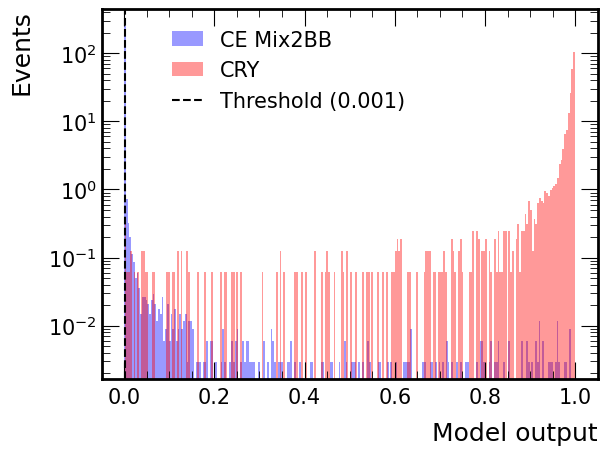

In [277]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # CRY
background_scores = test_scores[y_test == 0]  # CE + mix2BB

# Define threshold
threshold = optimal_threshold

# Compute FPR and FNR
false_positives = (background_scores > threshold).sum()   # Background misclassified as signal
true_negatives  = (background_scores <= threshold).sum()

false_negatives = (signal_scores <= threshold).sum()  # Signal misclassified as background
true_positives  = (signal_scores > threshold).sum()

fpr = false_positives / (false_positives + true_negatives)
fnr = false_negatives / (false_negatives + true_positives)

# Plot score distributions
plt.figure() 

plt.hist(background_scores, bins=250, alpha=0.4, label='CE Mix2BB',
         density=True, color='blue')
plt.hist(signal_scores, bins=250, alpha=0.4, label='CRY',
         density=True, color='red')

plt.axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


plt.xlabel('Model output')
plt.ylabel('Events')
plt.legend(loc="upper left", bbox_to_anchor=(0.1, 1))
plt.yscale('log')

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
out_name = img_validation_out_path / "model_output.png"
plt.savefig(out_name)
print(f"\tWrote {out_name}")
plt.show()


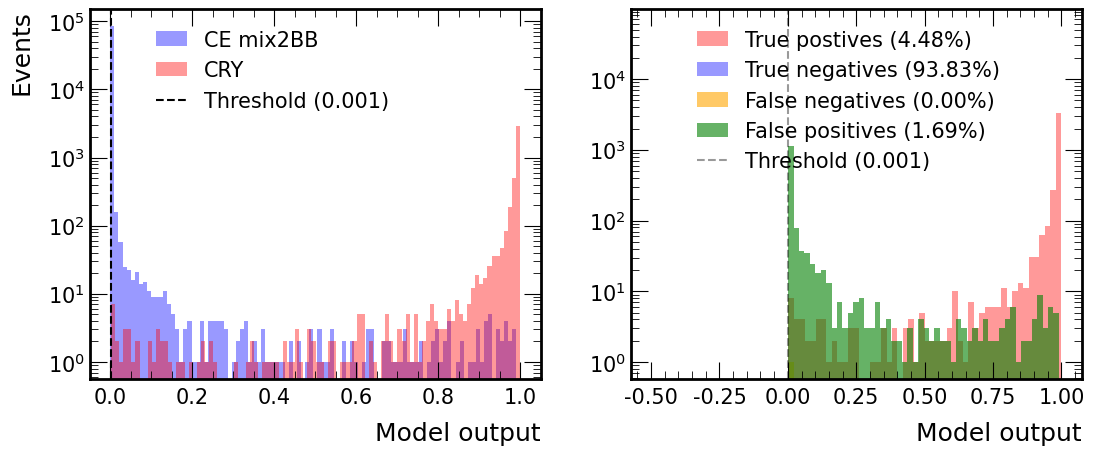

In [278]:
# Get test scores 
test_scores = model.predict_proba(X_test_scaled)[:, 1]

# Separate scores by true label
signal_scores = test_scores[y_test == 1]  # True signal (CRY)
background_scores = test_scores[y_test == 0]  # True background (CE mix)

# Discrimination threshold
threshold = optimal_threshold

# Get false positives and false negatives
false_positives = background_scores[background_scores > threshold]
false_negatives = signal_scores[signal_scores <= threshold]

# Also get true positives and true negatives for comparison
true_positives = signal_scores[signal_scores > threshold]
true_negatives = background_scores[background_scores <= threshold]

# # Boolean masks
# tp_mask = (y_test == 1) & (y_pred_label == 1)
# tn_mask = (y_test == 0) & (y_pred_label == 0)
# fp_mask = (y_test == 0) & (y_pred_label == 1)
# fn_mask = (y_test == 1) & (y_pred_label == 0)


tot = len(test_scores)

# Plot score distributions
fig, ax = plt.subplots(1, 2, figsize=(2*6.4, 4.8))

ax[0].hist(background_scores, bins=100, alpha=0.4, label='CE mix2BB',
         density=False, color='blue')
ax[0].hist(signal_scores, bins=100, alpha=0.4, label='CRY',
         density=False, color='red')
ax[0].axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5, label=f"Threshold ({optimal_threshold:.3f})")


ax[0].set_xlabel('Model output')
ax[0].set_ylabel('Events')
ax[0].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[0].set_yscale('log')


ax[1].hist(true_positives, bins=50, alpha=0.4, label=f'True postives ({len(true_positives)*100/tot:.2f}%)', color='red')
ax[1].hist(true_negatives, bins=50, alpha=0.4, label=f'True negatives ({len(true_negatives)*100/tot:.2f}%)', color='blue')
ax[1].hist(false_negatives, bins=50, alpha=0.6, label=f'False negatives ({len(false_negatives)*100/tot:.2f}%)', color='orange')
ax[1].hist(false_positives, bins=50, alpha=0.6, label=f'False positives ({len(false_positives)*100/tot:.2f}%)', color='green')
ax[1].axvline(optimal_threshold, color='black', linestyle='--', linewidth=1.5, alpha=0.4, label=f"Threshold ({optimal_threshold:.3f})")


ax[1].set_xlabel('Model output')
ax[1].legend(loc="upper left", bbox_to_anchor=(0.1, 1))
ax[1].set_yscale('log')


out_name = img_validation_out_path / "h1o_1x2_model_output.png"
plt.savefig(out_name)


plt.show()


In [279]:
# 95.43 + 

In [280]:
X_test_scaled

array([[-0.35855846, -0.37587871,  0.62443263, -0.38332802,  1.13812176],
       [-0.55888251, -0.30139635, -1.00164109, -0.32303997,  1.03147759],
       [-0.55888251,  2.04357683,  0.74161336,  1.79800307,  0.76315957],
       ...,
       [-0.90326853, -0.37409437,  1.66524083, -0.37510692, -0.30667992],
       [-0.03984767, -0.37445293,  1.04684505, -0.39154911,  1.83665074],
       [-0.55888251, -0.33531141,  0.28703631, -0.34222253,  0.39160514]])

	Wrote ../../../output/images/ml/veto/c/xgboost/validation/features_output.png


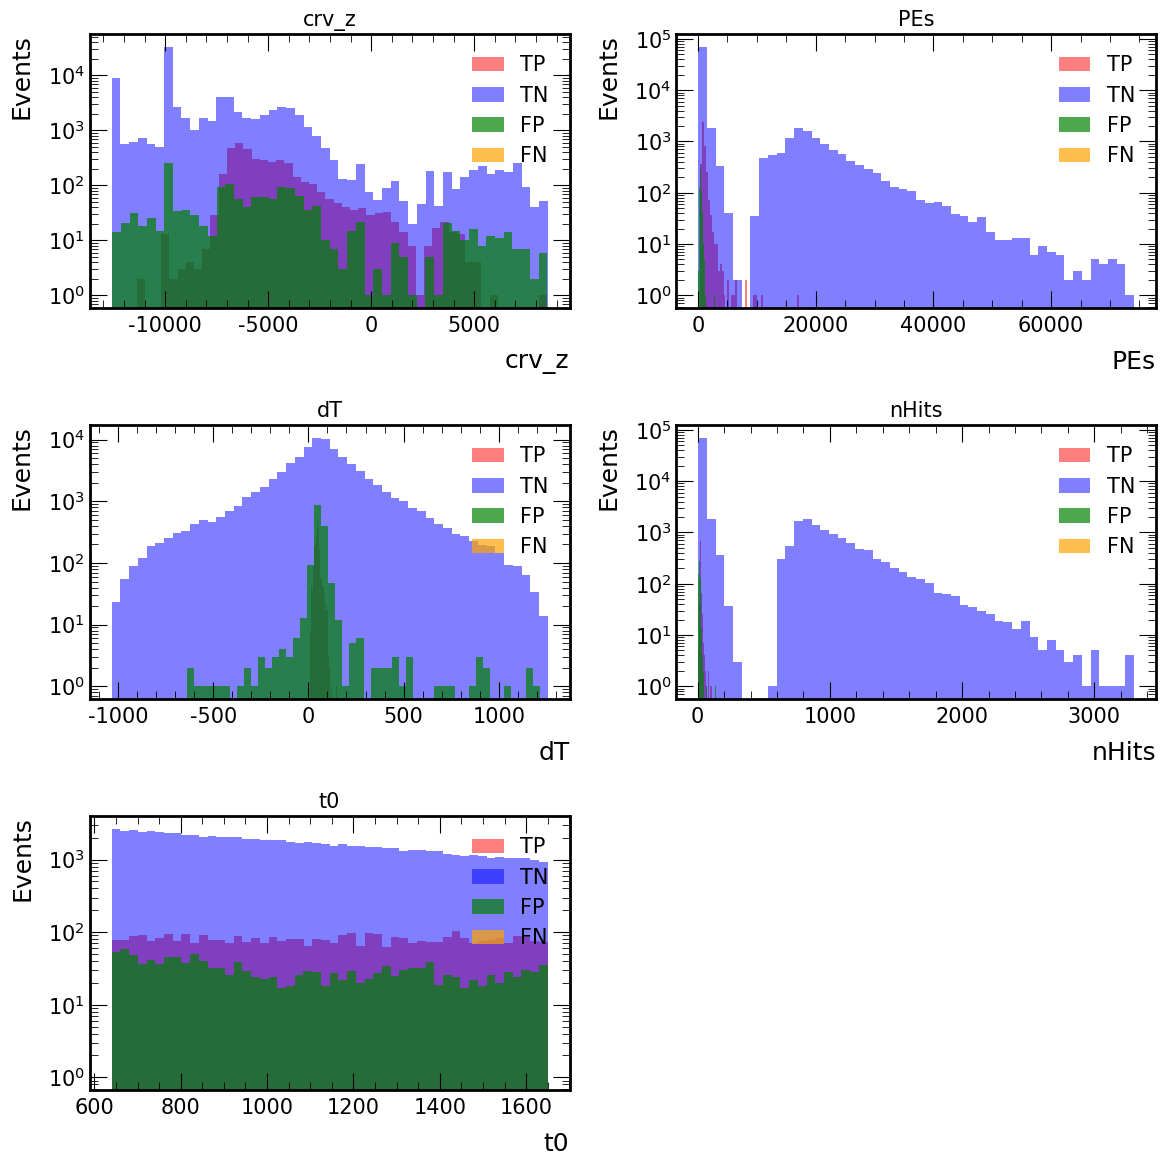

In [281]:
# Create a grid of subplots
n_features = len(feature_names)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division

y_pred_label = (test_scores > threshold).astype(int)
# Boolean masks
tp_mask = (y_test == 1) & (y_pred_label == 1)
tn_mask = (y_test == 0) & (y_pred_label == 0)
fp_mask = (y_test == 0) & (y_pred_label == 1)
fn_mask = (y_test == 1) & (y_pred_label == 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()

for idx, feature in enumerate(feature_names):
    ax = axes[idx]
    
    ax.hist(X_test[feature][tp_mask], bins=50, color='red', alpha=0.5, label='TP')
    ax.hist(X_test[feature][tn_mask], bins=50, color='blue', alpha=0.5, label='TN')
    ax.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.7, label='FP')
    ax.hist(X_test[feature][fn_mask], bins=50, color='orange', alpha=0.7, label='FN')
    xlabel = feature
    # if feature in ["d0", "maxr"]: 
    #     xlabel += " [mm]"
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Events')
    ax.set_yscale('log')
    ax.legend() # fontsize=8)


        
    ax.set_title(feature)

# Hide unused subplots
for idx in range(len(feature_names), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()

out_name = img_validation_out_path / "features_output.png" 
plt.savefig(out_name)
print(f"\tWrote {out_name}")

plt.show()

In [282]:
# true_positives.keys()

In [283]:
# Signal efficiency (True Positive Rate / Recall)
signal_efficiency = len(true_positives) / len(signal_scores)

# Background rejection rate (True Negative Rate / Specificity)
background_rejection = len(true_negatives) / len(background_scores)

# Background efficiency (what you're rejecting FROM)
background_efficiency = len(false_positives) / len(background_scores)

print(f"Signal Efficiency: {signal_efficiency*100:.2f}%") 
# plt.ylim(0.9999, 1)
print(f"Background Rejection: {background_rejection*100:.2f}%")
print(f"Background Contamination: {background_efficiency*100:.2f}%")

# Check class balance
print(f"\nClass balance:")
print(f"Signal events: {len(signal_scores)} ({len(signal_scores)*100/tot:.2f}%)")
print(f"Background events: {len(background_scores)} ({len(background_scores)*100/tot:.2f}%)")

Signal Efficiency: 99.98%
Background Rejection: 98.23%
Background Contamination: 1.77%

Class balance:
Signal events: 4016 (4.48%)
Background events: 85689 (95.52%)


In [284]:
# Evaluate on training set
y_train_pred_proba = model.predict_proba(X_train_scaled)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)

# Evaluate on test set
y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Train AUC: {train_auc:.4f}")
print(f"Test AUC:  {test_auc:.4f}")
print(f"Difference: {train_auc - test_auc:.4f}")

Train AUC: 0.9999
Test AUC:  0.9999
Difference: 0.0000


In [285]:
# Generate predictions on test set
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_proba > 0.5).astype(int)

print("\n" + "="*60)
print("CLASS BALANCE DIAGNOSTIC")
print("="*60)

# 1. Confusion matrix breakdown
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Create confusion matrix DataFrame
confusion_diagnostic_df = pd.DataFrame({
    'Category': [
        'True Negatives (correct background)',
        'False Positives (wrong veto)',
        'False Negatives (missed cosmic)',
        'True Positives (correct cosmic)'
    ],
    'Count': [tn, fp, fn, tp],
    'Percentage': [
        f"{tn/len(y_test)*100:.1f}%",
        f"{fp/len(y_test)*100:.1f}%",
        f"{fn/len(y_test)*100:.1f}%",
        f"{tp/len(y_test)*100:.1f}%"
    ]
})

print("\n📊 Confusion Matrix:")
display(confusion_diagnostic_df)

# 2. Per-class performance
per_class_metrics_df = pd.DataFrame({
    'Class': ['Signal (Cosmic Ray)', 'Signal (Cosmic Ray)', 'Signal (Cosmic Ray)',
              'Background (CE)', 'Background (CE)', 'Background (CE)'],
    'Metric': ['Recall (Sensitivity)', 'Precision (Purity)', 'F1 Score',
               'Recall (Specificity)', 'Precision', 'F1 Score'],
    'Value': [
        recall_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        f1_score(y_test, y_pred),
        recall_score(y_test, y_pred, pos_label=0),
        precision_score(y_test, y_pred, pos_label=0),
        f1_score(y_test, y_pred, pos_label=0)
    ]
})

print("\n📈 Per-Class Metrics:")
display(per_class_metrics_df)

# 3. Score distributions and baseline comparison
median_signal = np.median(y_pred_proba[y_test == 1])
median_bkg = np.median(y_pred_proba[y_test == 0])
naive_acc = np.sum(y_test == 0) / len(y_test)
model_acc = (tp + tn) / len(y_test)

additional_metrics_df = pd.DataFrame({
    'Metric': [
        'Signal median score',
        'Background median score',
        'Score separation',
        'Naive baseline accuracy',
        'Model accuracy',
        'Improvement over naive'
    ],
    'Value': [
        f"{median_signal:.4f}",
        f"{median_bkg:.4f}",
        f"{median_signal - median_bkg:.4f}",
        f"{naive_acc:.4f}",
        f"{model_acc:.4f}",
        f"{((model_acc - naive_acc) / naive_acc * 100):.1f}%"
    ]
})

print("\n🔍 Additional Diagnostics:")
display(additional_metrics_df)

print("="*60)


CLASS BALANCE DIAGNOSTIC

📊 Confusion Matrix:


,Category,Count,Percentage
0,True Negatives (correct background),85609,95.4%
1,False Positives (wrong veto),80,0.1%
2,False Negatives (missed cosmic),62,0.1%
3,True Positives (correct cosmic),3954,4.4%



📈 Per-Class Metrics:


,Class,Metric,Value
0,Signal (Cosmic Ray),Recall (Sensitivity),0.984562
1,Signal (Cosmic Ray),Precision (Purity),0.980169
2,Signal (Cosmic Ray),F1 Score,0.982360
3,Background (CE),Recall (Specificity),0.999066
4,Background (CE),Precision,0.999276
5,Background (CE),F1 Score,0.999171



🔍 Additional Diagnostics:


,Metric,Value
0,Signal median score,0.9945
1,Background median score,0.0000
2,Score separation,0.9945
3,Naive baseline accuracy,0.9552
4,Model accuracy,0.9984
5,Improvement over naive,4.5%



✅ Confusion matrix saved to ../../../output/images/ml/veto/c/xgboost/validation/confusion_matrix.png


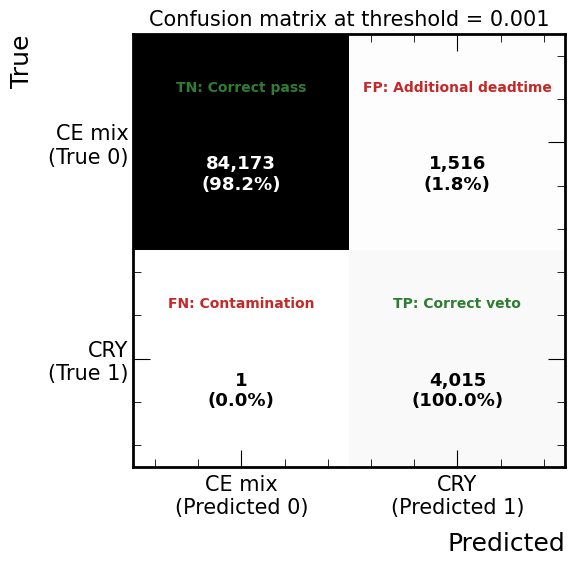

In [286]:
# Visualize confusion matrix with counts and percentages
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Use optimal threshold
y_pred_optimal = (y_test_pred_proba > optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm.ravel()

# Create custom confusion matrix plot
fig, ax = plt.subplots(figsize=(8, 6))

# Display the confusion matrix as an image
# Try these colormap alternatives:
# 'Blues', 'Greens', 'Purples', 'Oranges', 'Greys'
# 'YlOrRd', 'YlGnBu', 'RdPu', 'BuPu', 'GnBu'
# 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
im = ax.imshow(cm, interpolation="nearest", cmap="Greys")

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['CE mix\n(Predicted 0)', 'CRY\n(Predicted 1)'])
ax.set_yticklabels(['CE mix\n(True 0)', 'CRY\n(True 1)'])

ax.set_xlabel('Predicted') # , fontsize=12, fontweight='bold')
ax.set_ylabel('True') # , fontsize=12, fontweight='bold')
ax.set_title(f'Confusion matrix at threshold = {optimal_threshold:.3f}') # , fontsize=13, fontweight='bold')

# Calculate percentages (normalised by row - by true label)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Add text annotations with both counts and percentages
thresh = cm.max() / 2.
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = cm_norm[i, j] * 100
        
        # Determine if we need white or black text
        text_color = "white" if cm[i, j] > thresh else "black"
        
        # Add interpretation labels at top
        if i == 0 and j == 0:  # TN
            label = 'TN: Correct pass'
            label_color = '#2E7D32'  # Dark green
        elif i == 0 and j == 1:  # FP
            label = 'FP: Additional deadtime'
            label_color = '#C62828'  # Dark red
        elif i == 1 and j == 0:  # FN
            label = 'FN: Contamination'
            label_color = '#C62828'  # Dark red
        else:  # TP
            label = 'TP: Correct veto'
            label_color = '#2E7D32'  # Gold/yellow for visibility
        
        ax.text(j, i - 0.25, label,
                ha="center", va="center",
                color=label_color, fontsize=10, fontweight='bold')
        
        # Count and percentage below
        ax.text(j, i + 0.15, f'{count:,}\n({percentage:.1f}%)',
                ha="center", va="center",
                color=text_color,
                fontsize=13, fontweight='bold')

plt.tight_layout()

out_name = img_validation_out_path / "confusion_matrix.png"
plt.savefig(out_name) # , dpi=150, bbox_inches='tight')
print(f"\n✅ Confusion matrix saved to {out_name}")

plt.show()

# # Print summary
# print("\n" + "="*70)
# print("CONFUSION MATRIX BREAKDOWN")
# print("="*70)
# print(f"\nPure CRY sample (label 1): {tp+fn:,} events")
# print(f"  ✓ Correctly vetoed (TP):     {tp:,} ({tp/(tp+fn)*100:.2f}%)")
# print(f"  ✗ Incorrectly passed (FN):   {fn:,} ({fn/(tp+fn)*100:.2f}%)")

# print(f"\nCE mix sample (label 0): {tn+fp:,} events")
# print(f"  ✓ Correctly passed (TN):     {tn:,} ({tn/(tn+fp)*100:.2f}%)")
# print(f"  ✗ Incorrectly vetoed (FP):   {fp:,} ({fp/(tn+fp)*100:.2f}%)")

# print(f"\nTotal: {len(y_test):,} events")
# print(f"  Correct predictions:         {tp+tn:,} ({(tp+tn)/len(y_test)*100:.2f}%)")
# print(f"  Incorrect predictions:       {fp+fn:,} ({(fp+fn)/len(y_test)*100:.2f}%)")
# print("="*70)

## CRV Veto Performance Metrics

**Physics context**: Veto pure cosmic rays while preserving the CE beam sample.

### Key insight:
The CE mix2BB sample contains:
- True CE signal coincidences 
- Pileup-induced cosmic coincidences

**We want to PASS THROUGH the entire CE mix sample** (both CE signal + pileup cosmics) because:
- Vetoing pileup cosmics = unnecessary deadtime inflation
- Pileup cosmics in CE mix don't contaminate the physics signal the same way pure cosmics do

### Training strategy:
- **Label 1 (CRY)**: Pure cosmic sample → VETO these
- **Label 0 (CE mix)**: Mixed CE sample → PASS these (accept both CE + pileup)

### Model performance metrics:
- **Veto Efficiency (ε_veto)**: Fraction of pure cosmic rays correctly vetoed
- **Veto Inefficiency (1 - ε_veto)**: Fraction of pure cosmic rays that slip through (contamination)
- **Deadtime**: Fraction of CE mix events incorrectly vetoed (pure loss)
- **Veto Purity**: Of vetoed events, what fraction are truly from pure cosmic sample

In [287]:
# ==========================================
# CRV VETO PERFORMANCE METRICS
# ==========================================

# LABELS:
#   Label 1 (CRY): Pure cosmic sample - want to VETO
#   Label 0 (CE mix): Mixed CE sample (true CE + pileup cosmics) - want to PASS
#
# PHYSICS GOAL:
#   VETO: Pure cosmic rays (out-of-time backgrounds)
#   PASS: Entire CE mix sample (CE signal + pileup cosmics)
#   
#   Why pass pileup cosmics? Vetoing them inflates deadtime without benefit!

# Get predictions at optimal threshold
y_pred_veto = (y_test_pred_proba > optimal_threshold).astype(int)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_veto)
tn, fp, fn, tp = cm.ravel()

# INTERPRETATION:
# TP (True Positives)  = Pure CRY correctly vetoed → GOOD ✓
# FN (False Negatives) = Pure CRY missed (passed through) → BAD ✗ (contamination!)
# TN (True Negatives)  = CE mix passed through → GOOD ✓ (desired behavior)
# FP (False Positives) = CE mix incorrectly vetoed → BAD ✗ (deadtime inflation!)

# print("\n" + "="*80)
# print("CRV VETO PERFORMANCE @ OPTIMAL THRESHOLD")
# print("="*80)

# Core veto metrics
veto_efficiency = tp / (tp + fn)  # Fraction of pure cosmics caught
veto_inefficiency = fn / (tp + fn)  # Fraction of pure cosmics that leak through
deadtime_loss = fp / (tn + fp)  # Fraction of CE mix incorrectly vetoed
veto_purity = tp / (tp + fp) if (tp + fp) > 0 else 0  # Of vetoed events, fraction that are pure cosmics

# print(f"\n📊 VETO EFFICIENCY (Pure Cosmic Rejection):")
# print(f"   Pure CRY correctly vetoed (TP):   {tp:,} / {tp+fn:,}")
# print(f"   Veto Efficiency (ε_veto):         {veto_efficiency:.4f} ({veto_efficiency*100:.2f}%)")
# print(f"   Veto Inefficiency (1-ε_veto):     {veto_inefficiency:.6f} ({veto_inefficiency*100:.4f}%)")
# print(f"   → Cosmic contamination = {veto_inefficiency:.2e}")
# print(f"\n   ⚠️  These pure cosmics contaminate your sample!")

# print(f"\n⏱️  DEADTIME (CE Mix Incorrectly Vetoed):")
# print(f"   CE mix correctly passed (TN):     {tn:,} / {tn+fp:,}")
# print(f"   CE mix incorrectly vetoed (FP):   {fp:,} / {tn+fp:,}")
# print(f"   Deadtime fraction:                {deadtime_loss:.4f} ({deadtime_loss*100:.2f}%)")
# print(f"\n   ⚠️  Vetoing CE mix = pure deadtime loss!")
# print(f"       (includes both true CE + pileup cosmics - both undesirable to veto)")

# print(f"\n✅ VETO PURITY:")
# print(f"   Total events vetoed:              {tp+fp:,}")
# print(f"   - Pure CRY (good veto):           {tp:,} ({tp/(tp+fp)*100:.1f}%)")
# print(f"   - CE mix (bad veto/deadtime):     {fp:,} ({fp/(tp+fp)*100:.1f}%)")
# print(f"   Veto purity:                      {veto_purity:.4f} ({veto_purity*100:.2f}%)")

# print(f"\n⚡ SUMMARY:")
# print(f"   Total test events:                {len(y_test):,}")
# print(f"   Correctly classified:             {tp+tn:,} ({(tp+tn)/len(y_test)*100:.1f}%)")
# print(f"   Misclassified:                    {fp+fn:,} ({(fp+fn)/len(y_test)*100:.1f}%)")
# print(f"     - Contamination (FN):           {fn:,} (pure cosmics leaked)")
# print(f"     - Deadtime (FP):                {fp:,} (CE mix wrongly vetoed)")

print("="*70)

In [288]:
# ==========================================
# SAVE CRV VETO METRICS TO CSV
# ==========================================

# Create results directory
results_out_path = Path(f"../../../output/ml/veto/xgboost/{run}/results")
results_out_path.mkdir(parents=True, exist_ok=True)

# Calculate all metrics
metrics_data = {
    'Metric': [
        'Veto efficiency (Pure CRY)',
        'Veto inefficiency (Pure CRY)', 
        'CE mix veto rate (Additional deadtime)',
        'CE mix pass rate',
        'Veto purity',
        'Overall accuracy'
    ],
    'Formula': [
        'TP / (TP + FN)',
        'FN / (TP + FN)',
        'FP / (TN + FP)',
        'TN / (TN + FP)',
        'TP / (TP + FP)',
        '(TP + TN) / (TP + TN + FP + FN)'
    ],
    'Value': [
        veto_efficiency,
        veto_inefficiency,
        deadtime_loss,
        1 - deadtime_loss,  # CE Mix Pass Rate = 1 - deadtime
        veto_purity,
        (tp + tn) / (tp + tn + fp + fn)
    ],
    'Description': [
        'Fraction of pure cosmic rays successfully vetoed',
        'Fraction of pure cosmic rays that slip through (contamination)',
        'Fraction of CE mix events vetoed (deadtime)',
        'Fraction of CE mix events passed through (preserved beam data)',
        'Of all vetoed events, fraction that are pure cosmics',
        'Overall correct classification rate'
    ]
}

# Add confusion matrix counts
confusion_data = {
    'Metric': ['True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)'],
    'Count': [int(tp), int(tn), int(fp), int(fn)],
    'Description': [
        'Pure CRY correctly vetoed',
        'CE mix correctly passed',
        'CE mix incorrectly vetoed (additional deadtime)',
        'Pure CRY incorrectly passed (contamination)'
    ]
}

# Create DataFrames
metrics_df = pd.DataFrame(metrics_data)
confusion_df = pd.DataFrame(confusion_data)

# Save to CSV files
metrics_file_path = results_out_path / "crv_metrics_results.csv"
confusion_file_path = results_out_path / "confusion_matrix_counts.csv"

metrics_df.to_csv(metrics_file_path, index=False, float_format='%.6f')
confusion_df.to_csv(confusion_file_path, index=False)

print(f"\n✅ CRV metrics saved to:")
print(f"   {metrics_file_path}")
print(f"   {confusion_file_path}")

# Display the results
print("\n" + "="*80)
print("CRV VETO METRICS SUMMARY")
print("="*80)
display(metrics_df)

print("\n" + "="*80)
print("CONFUSION MATRIX COUNTS")
print("="*80)
display(confusion_df)



✅ CRV metrics saved to:
   ../../../output/ml/veto/xgboost/c/results/crv_metrics_results.csv
   ../../../output/ml/veto/xgboost/c/results/confusion_matrix_counts.csv

CRV VETO METRICS SUMMARY


,Metric,Formula,Value,Description
0,Veto efficiency (Pure CRY),TP / (TP + FN),0.999751,Fraction of pure cosmic rays successfully vetoed
1,Veto inefficiency (Pure CRY),FN / (TP + FN),0.000249,Fraction of pure cosmic rays that slip through...
2,CE mix veto rate (Additional deadtime),FP / (TN + FP),0.017692,Fraction of CE mix events vetoed (deadtime)
3,CE mix pass rate,TN / (TN + FP),0.982308,Fraction of CE mix events passed through (pres...
4,Veto purity,TP / (TP + FP),0.725909,"Of all vetoed events, fraction that are pure c..."
5,Overall accuracy,(TP + TN) / (TP + TN + FP + FN),0.983089,Overall correct classification rate



CONFUSION MATRIX COUNTS


,Metric,Count,Description
0,True Positives (TP),4015,Pure CRY correctly vetoed
1,True Negatives (TN),84173,CE mix correctly passed
2,False Positives (FP),1516,CE mix incorrectly vetoed (additional deadtime)
3,False Negatives (FN),1,Pure CRY incorrectly passed (contamination)


## Comparison with simple dT cut

Compare ML performance with traditional veto window: -25 < dT < 150 ns

In [289]:
# ==========================================
# SIMPLE dT CUT COMPARISON
# ==========================================
# Apply traditional veto window: -25 < dT < 150 ns
# If dT is in this window, predict it's a cosmic (label 1)

# Get dT values from test set
dT_test = X_test['dT'].values

# Apply simple cut: veto if dT in [-25, 150]
y_pred_dt_cut = ((dT_test >= -25) & (dT_test <= 150)).astype(int)

# # Get dT values from test set
# dT = X['dT'].values

# # Apply simple cut: veto if dT in [-25, 150]
# y_pred_dt_cut = ((dT >= -25) & (dT <= 150)).astype(int)


# Calculate confusion matrix for dT cut
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred_dt_cut)
tn_dt, fp_dt, fn_dt, tp_dt = cm_dt.ravel()

# Calculate metrics for dT cut
veto_efficiency_dt = tp_dt / (tp_dt + fn_dt)
veto_inefficiency_dt = fn_dt / (tp_dt + fn_dt)
deadtime_loss_dt = fp_dt / (tn_dt + fp_dt)
veto_purity_dt = tp_dt / (tp_dt + fp_dt) if (tp_dt + fp_dt) > 0 else 0

# Create comparison DataFrames
print("\n" + "="*80)
print("PERFORMANCE COMPARISON: ML MODEL vs SIMPLE dT CUT")
print("="*80)

# Metrics comparison
metrics_comparison_df = pd.DataFrame({
    'Metric': [
        'Veto efficiency',
        'Deadtime',
        'Figure of merit'
    ],
    'ML Model': [
        f"{veto_efficiency*100:.2f}%",
        f"{deadtime_loss*100:.2f}%",
        f"{veto_efficiency * (1 - deadtime_loss):.4f}"
    ],
    'dT Cut': [
        f"{veto_efficiency_dt*100:.2f}%",
        f"{deadtime_loss_dt*100:.2f}%",
        f"{veto_efficiency_dt * (1 - deadtime_loss_dt):.4f}"
    ],
    'Difference': [
        f"{(veto_efficiency - veto_efficiency_dt)*100:+.2f}%",
        f"{(deadtime_loss - deadtime_loss_dt)*100:+.2f}%",
        f"{(veto_efficiency * (1 - deadtime_loss)) - (veto_efficiency_dt * (1 - deadtime_loss_dt)):+.4f}"
    ]
})

# Confusion matrix comparison
confusion_comparison_df = pd.DataFrame({
    'Category': [
        'True Positives (CRY vetoed)',
        'True Negatives (CE mix passed)',
        'False Positives (CE mix vetoed)',
        'False Negatives (CRY leaked)'
    ],
    'ML Model': [tp, tn, fp, fn],
    'dT Cut': [tp_dt, tn_dt, fp_dt, fn_dt],
    'Difference': [tp - tp_dt, tn - tn_dt, fp - fp_dt, fn - fn_dt]
})

print("\n📊 Performance Metrics:")
display(metrics_comparison_df)

print("\n📈 Confusion Matrix Counts:")
display(confusion_comparison_df)

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Veto efficiency comparison
print(f"\n🎯 Veto Efficiency (catching pure CRY):")
print(f"   ML: {tp:,}/{tp+fn:,} CRY vetoed ({veto_efficiency*100:.2f}%)")
print(f"   dT: {tp_dt:,}/{tp_dt+fn_dt:,} CRY vetoed ({veto_efficiency_dt*100:.2f}%)")
print(f"   → ML catches {tp - tp_dt:,} {'fewer' if tp < tp_dt else 'more'} CRY events ({(veto_efficiency - veto_efficiency_dt)*100:+.2f}%)")

# CRY leakage comparison
print(f"\n⚠️  CRY Leakage (contamination):")
print(f"   ML: {fn:,} CRY leaked ({veto_inefficiency*100:.4f}%)")
print(f"   dT: {fn_dt:,} CRY leaked ({veto_inefficiency_dt*100:.4f}%)")
print(f"   → ML leaks {abs(fn - fn_dt):,} {'fewer' if fn < fn_dt else 'more'} CRY events ({(veto_inefficiency - veto_inefficiency_dt)*100:+.4f}%)")

# Deadtime comparison
print(f"\n⏱️  Additional Deadtime (CE mix incorrectly vetoed):")
print(f"   ML: {fp:,}/{fp+tn:,} CE mix vetoed ({deadtime_loss*100:.2f}%)")
print(f"   dT: {fp_dt:,}/{fp_dt+tn_dt:,} CE mix vetoed ({deadtime_loss_dt*100:.2f}%)")
print(f"   → ML vetoes {abs(fp - fp_dt):,} {'fewer' if fp < fp_dt else 'more'} CE mix events ({(deadtime_loss - deadtime_loss_dt)*100:+.2f}%)")

# Overall trade-off
print(f"\n💡 Trade-off Summary:")
print(f"   ML sacrifices {abs(tp - tp_dt):,} CRY vetoes (slight efficiency loss)")
print(f"   To gain {abs(tn - tn_dt):,} CE mix passes (major deadtime reduction)")
print(f"   Net benefit: {abs(deadtime_loss - deadtime_loss_dt)*100:.1f}% less deadtime vs {abs(veto_efficiency - veto_efficiency_dt)*100:.1f}% efficiency loss")

print("="*80)


PERFORMANCE COMPARISON: ML MODEL vs SIMPLE dT CUT

📊 Performance Metrics:


,Metric,ML Model,dT Cut,Difference
0,Veto efficiency,99.98%,99.98%,+0.00%
1,Deadtime,1.77%,41.99%,-40.22%
2,Figure of merit,0.9821,0.5800,+0.4021



📈 Confusion Matrix Counts:


,Category,ML Model,dT Cut,Difference
0,True Positives (CRY vetoed),4015,4015,0
1,True Negatives (CE mix passed),84173,49712,34461
2,False Positives (CE mix vetoed),1516,35977,-34461
3,False Negatives (CRY leaked),1,1,0



KEY FINDINGS

🎯 Veto Efficiency (catching pure CRY):
   ML: 4,015/4,016 CRY vetoed (99.98%)
   dT: 4,015/4,016 CRY vetoed (99.98%)
   → ML catches 0 more CRY events (+0.00%)

⚠️  CRY Leakage (contamination):
   ML: 1 CRY leaked (0.0249%)
   dT: 1 CRY leaked (0.0249%)
   → ML leaks 0 more CRY events (+0.0000%)

⏱️  Additional Deadtime (CE mix incorrectly vetoed):
   ML: 1,516/85,689 CE mix vetoed (1.77%)
   dT: 35,977/85,689 CE mix vetoed (41.99%)
   → ML vetoes 34,461 fewer CE mix events (-40.22%)

💡 Trade-off Summary:
   ML sacrifices 0 CRY vetoes (slight efficiency loss)
   To gain 34,461 CE mix passes (major deadtime reduction)
   Net benefit: 40.2% less deadtime vs 0.0% efficiency loss


In [290]:
# # Example traditional cuts (adjust these to your physics case)
# def apply_kin_cuts(X):
#     """Apply kinematic parameter cuts for signal selection"""
#     cuts = (
#         (X['d0'] < 100) &           
#         (X['maxr'] < 680) &         
#         (X['tanDip'] > 0.5) &  
#         (X['tanDip'] < 1.0) # &        
#         # (X['t0err'] < 0.9)   
#     )
#     return cuts

# # Apply cuts to test set

# cut_based_pred = apply_kin_cuts(X_test).astype(int)

# print(X_test)
# print(len(cut_based_pred[cut_based_pred==1])/len(cut_based_pred))
# # print(len(X_test), len(cut_based_pred[2]))
# # cut_based_pred = apply_kin_cuts(X_test).astype(int)

In [291]:
# from sklearn.metrics import confusion_matrix, classification_report

# # ML predictions
# y_pred_ml = (test_scores > optimal_threshold).astype(int)

# # Calculate confusion matrices
# cm_ml = confusion_matrix(y_test, y_pred_ml)
# cm_cuts = confusion_matrix(y_test, cut_based_pred)

# # Extract TP, TN, FP, FN for both methods
# def get_metrics(cm):
#     tn, fp, fn, tp = cm.ravel()
    
#     signal_efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
#     background_rejection = tn / (tn + fp) if (tn + fp) > 0 else 0
#     purity = tp / (tp + fp) if (tp + fp) > 0 else 0
    
#     # Calculate significance
#     S = tp
#     B = fp
#     significance = S / np.sqrt(S + B) if (S + B) > 0 else 0
    
#     return {
#         'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
#         'Signal efficiency': signal_efficiency,
#         'Background rejection': background_rejection,
#         'Purity': purity,
#         'Significance': significance
#     }

# metrics_ml = get_metrics(cm_ml)
# metrics_cuts = get_metrics(cm_cuts)

# # # Print comparison
# # print("=" * 60)
# # print("Performance comparison: ML vs kinematic cuts")
# # print("=" * 60)
# # print(f"{'Metric':<25} {'ML':<15} {'Cuts':<15} {'Improvement':<15}")
# # print("-" * 60)

# # for key in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']:
# #     ml_val = metrics_ml[key]
# #     cut_val = metrics_cuts[key]
# #     improvement = ((ml_val - cut_val) / cut_val * 100) if cut_val > 0 else 0
    
# #     print(f"{key:<25} {ml_val:.4f}        {cut_val:.4f}        {improvement:+.1f}%")

# # print("-" * 60)
# # print(f"{'True positives':<25} {metrics_ml['TP']:<15} {metrics_cuts['TP']:<15}")
# # print(f"{'False positives':<25} {metrics_ml['FP']:<15} {metrics_cuts['FP']:<15}")
# # print(f"{'False negatives':<25} {metrics_ml['FN']:<15} {metrics_cuts['FN']:<15}")
# # print(f"{'True negatives':<25} {metrics_ml['TN']:<15} {metrics_cuts['TN']:<15}")


# # Metrics DataFrame (with percentages/rates)
# metrics_df = pd.DataFrame({
#     'Metric': ['Signal efficiency', 'Background rejection', 'Purity', 'Significance'],
#     'ML': [metrics_ml[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']],
#     'Cuts': [metrics_cuts[k] for k in ['Signal efficiency', 'Background rejection', 'Purity', 'Significance']]
# })
# metrics_df['Improvement [%]'] = ((metrics_df['ML'] - metrics_df['Cuts']) / metrics_df['Cuts'] * 100)

# # Counts DataFrame
# # counts_df = pd.DataFrame({
# #     'Category': ['True positives', 'False positives', 'False negatives', 'True negatives'],
# #     'ML': [metrics_ml['TP'], metrics_ml['FP'], metrics_ml['FN'], metrics_ml['TN']],
# #     'Cuts': [metrics_cuts['TP'], metrics_cuts['FP'], metrics_cuts['FN'], metrics_cuts['TN']]
# # })

# counts_df = pd.DataFrame({
#     'Category': ['True positives', 'True negatives', 'False positives', 'False negatives'],
#     'ML': [metrics_ml['TP'], metrics_ml['TN'], metrics_ml['FP'], metrics_ml['FN']],
#     'Cuts': [metrics_cuts['TP'], metrics_cuts['TN'], metrics_cuts['FP'], metrics_cuts['FN']]
# })

# counts_df['Difference'] = counts_df['ML'] - counts_df['Cuts']

# print("\n=== Performance metrics ===")
# display(metrics_df)
# print("\n=== Event counts ===")
# display(counts_df)



In [292]:
# # Cosmic Ray Rejection Performance Table
# cosmic_rejection_df = pd.DataFrame({
#     'Metric': [
#         'Cosmic rays rejected (TN)',
#         'Cosmic rays accepted (FP)', 
#         'Background rejection rate',
#         'Cosmic contamination rate',
#         'Sample purity (beam)',
#         'Beam events retained (TP)',
#         'Beam signal efficiency',
#         'Overall significance (S/√(S+B))'
#     ],
#     'ML': [
#         metrics_ml['TN'],
#         metrics_ml['FP'],
#         f"{metrics_ml['Background rejection']*100:.2f}%",
#         f"{(metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']))*100:.2f}%",
#         f"{metrics_ml['Purity']*100:.2f}%",
#         metrics_ml['TP'],
#         f"{metrics_ml['Signal efficiency']*100:.2f}%",
#         f"{metrics_ml['Significance']:.1f}"
#     ],
#     'Cuts': [
#         metrics_cuts['TN'],
#         metrics_cuts['FP'],
#         f"{metrics_cuts['Background rejection']*100:.2f}%",
#         f"{(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100:.2f}%",
#         f"{metrics_cuts['Purity']*100:.2f}%",
#         metrics_cuts['TP'],
#         f"{metrics_cuts['Signal efficiency']*100:.2f}%",
#         f"{metrics_cuts['Significance']:.1f}"
#     ],
#     'Improvement': [
#         f"+{metrics_ml['TN'] - metrics_cuts['TN']}",
#         f"{metrics_ml['FP'] - metrics_cuts['FP']}",
#         f"+{((metrics_ml['Background rejection'] - metrics_cuts['Background rejection'])/metrics_cuts['Background rejection']*100):.1f}%",
#         f"{((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%",
#         f"+{(metrics_ml['Purity'] - metrics_cuts['Purity'])*100:.2f}%",
#         f"+{metrics_ml['TP'] - metrics_cuts['TP']}",
#         f"+{((metrics_ml['Signal efficiency'] - metrics_cuts['Signal efficiency'])/metrics_cuts['Signal efficiency']*100):.1f}%",
#         f"+{((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}%"
#     ]
# })

# print("\n" + "="*80)
# print("COSMIC RAY REJECTION PERFORMANCE: ML vs Kinematic Cuts")
# print("="*80)
# display(cosmic_rejection_df)

# # Add summary statistics
# total_cosmics = metrics_ml['TN'] + metrics_ml['FP']
# total_beam = metrics_ml['TP'] + metrics_ml['FN']

# print("\n" + "="*80)
# print("KEY FINDINGS")
# print("="*80)
# print(f"• ML rejects {metrics_ml['TN'] - metrics_cuts['TN']} additional cosmic ray backgrounds")
# print(f"• ML reduces cosmic contamination by {abs((metrics_ml['FP']/(metrics_ml['FP']+metrics_ml['TN']) - metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))/(metrics_cuts['FP']/(metrics_cuts['FP']+metrics_cuts['TN']))*100):.1f}%")
# print(f"• ML retains {metrics_ml['TP'] - metrics_cuts['TP']} additional beam events")
# print(f"• Net result: {((metrics_ml['Significance'] - metrics_cuts['Significance'])/metrics_cuts['Significance']*100):.1f}% improvement in significance")
# print(f"\nDataset composition: {total_beam:,} beam events, {total_cosmics:,} cosmic events")

In [46]:
# # # Selection rate on PURE signal dataset
# # signal_selection_rate = metrics_cuts['TP'] / (metrics_cuts['TP'] + metrics_cuts['FN'])
# # print(f"Signal selection rate (cuts): {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")

# # # This is actually the same as signal efficiency!
# # # It's asking: "Of all signal events, what fraction passes cuts?"

# # # For comparison - ML signal selection rate
# # signal_selection_rate_ml = metrics_ml['TP'] / (metrics_ml['TP'] + metrics_ml['FN'])
# # print(f"Signal selection rate (ML): {signal_selection_rate_ml:.4f} ({signal_selection_rate_ml*100:.2f}%)")

# # # Background selection rate (what fraction of background passes - you want this LOW)
# # background_selection_rate_cuts = metrics_cuts['FP'] / (metrics_cuts['FP'] + metrics_cuts['TN'])
# # background_selection_rate_ml = metrics_ml['FP'] / (metrics_ml['FP'] + metrics_ml['TN'])

# # print(f"\nBackground selection rate (cuts): {background_selection_rate_cuts:.4f} ({background_selection_rate_cuts*100:.2f}%)")
# # print(f"Background selection rate (ML): {background_selection_rate_ml:.4f} ({background_selection_rate_ml*100:.2f}%)")

# # Apply cuts to the pure signal dataset
# cut_based_sig = apply_kin_cuts(df_sig.drop('label', axis=1))

# # Calculate selection rate on pure signal sample
# signal_selection_rate = cut_based_sig.sum() / len(df_sig)
# print(f"Selection rate on pure signal dataset: {signal_selection_rate:.4f} ({signal_selection_rate*100:.2f}%)")
# print(f"Events passing cuts: {cut_based_sig.sum()} / {len(df_sig)}")

# # Compare to what you got on test set
# print(f"\nFor comparison:")
# print(f"Signal efficiency on test set: {metrics_cuts['Signal efficiency']:.4f} ({metrics_cuts['Signal efficiency']*100:.2f}%)")

# # Apply cuts to pure background dataset
# cut_based_bkg = apply_kin_cuts(df_bkg.drop('label', axis=1))

# background_selection_rate = cut_based_bkg.sum() / len(df_bkg)
# print(f"Selection rate on pure background dataset: {background_selection_rate:.4f} ({background_selection_rate*100:.2f}%)")
# print(f"\nFor comparison:")
# print(f"Background contamination on test set: {1 - metrics_cuts['Background rejection']:.4f} ({(1 - metrics_cuts['Background rejection'])*100:.2f}%)")

In [47]:
# from sklearn.metrics import roc_curve, auc

# # ML ROC curve
# fpr_ml, tpr_ml, _ = roc_curve(y_test, test_scores)
# roc_auc_ml = auc(fpr_ml, tpr_ml)

# # For cut-based, create a simple ROC point
# tpr_cuts = metrics_cuts['Signal efficiency']
# fpr_cuts = 1 - metrics_cuts['Background rejection']

# plt.figure(figsize=(8, 6))
# plt.plot(fpr_ml, tpr_ml, label=f'ML (AUC = {roc_auc_ml:.3f})', linewidth=2)
# plt.scatter(fpr_cuts, tpr_cuts, color='blue', s=100, zorder=5, 
#            label=f'Kinematic cuts', marker='o')
# plt.plot([0, 1], [0, 1], 'k--', label='Random')
# plt.xlabel(r'False positive rate (1 $-$ background rejection)')
# plt.ylabel('True positive rate (signal efficiency)')
# plt.title('ROC curve: ML vs cuts')
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.tight_layout()

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
# out_name = f"{out_path}/roc_curve_kin_cuts.png"
# plt.savefig(out_name)


# plt.show()

In [48]:
# # Scan thresholds for both methods
# thresholds_ml = np.linspace(0, 1, 100)
# significance_ml = []

# for thr in thresholds_ml:
#     y_pred = (test_scores > thr).astype(int)
#     S = ((y_test == 1) & (y_pred == 1)).sum()
#     B = ((y_test == 0) & (y_pred == 1)).sum()
#     sig = S / np.sqrt(S + B) if (S + B) > 0 else 0
#     significance_ml.append(sig)

# # Get cut-based significance (single point)
# S_cuts = metrics_cuts['TP']
# B_cuts = metrics_cuts['FP']
# sig_cuts = metrics_cuts['Significance']

# plt.figure() # figsize=(10, 6))
# plt.plot(thresholds_ml, significance_ml, label='ML', linewidth=2)
# plt.axhline(sig_cuts, color='grey', linestyle='--', linewidth=2, 
#            label=f'Cuts (Sig = {sig_cuts:.2f})')
# plt.axvline(optimal_threshold, color='grey', linewidth=2, linestyle=':',
#            label=f'Optimal threshold ({optimal_threshold:.3f})')
# plt.xlabel('Threshold')
# plt.ylabel(r'Significance ($S/\sqrt{S+B}$)')
# plt.title('Signal significance: ML vs cuts')
# plt.legend(loc="lower left")
# plt.grid(alpha=0.3)
# plt.tight_layout()

# out_path = Path(f"../../output/images/ml/{run}") # /roc_curve.png"
# out_path.mkdir(parents=False, exist_ok=True)
# out_name = f"{out_path}/sig_sif_mix_kin_cuts.png"
# plt.savefig(out_name)

# plt.show()

# print(f"\nMaximum ML Significance: {max(significance_ml):.2f}")
# print(f"Cut-based Significance: {sig_cuts:.2f}")
# print(f"Improvement: {(max(significance_ml) - sig_cuts)/sig_cuts*100:.1f}%")

In [49]:
# # Show which events pass ML but fail cuts, and vice versa
# ml_only = (y_pred_ml == 1) & (cut_based_pred == 0)
# cuts_only = (y_pred_ml == 0) & (cut_based_pred == 1)
# both = (y_pred_ml == 1) & (cut_based_pred == 1)

# print(f"\nEvents passing ML only: {ml_only.sum()}")
# print(f"Events passing Cuts only: {cuts_only.sum()}")
# print(f"Events passing both: {both.sum()}")

In [50]:
# feature = 'd0'

# plt.figure(figsize=(8,6))
# plt.hist(X_test[feature][tp_mask], bins=50, color='royalblue', alpha=0.5, label='True Positives')
# plt.hist(X_test[feature][fp_mask], bins=50, color='green', alpha=0.5, label='False Positives')
# plt.hist(X_test[feature][fn_mask], bins=50, color='khaki', alpha=0.7, label='False Negatives')
# plt.hist(X_test[feature][tn_mask], bins=50, color='red', alpha=0.5, label='True Negatives')
# plt.xlabel(feature)
# plt.ylabel('# of events')
# plt.yscale('log')
# plt.legend()
# plt.title(f'{feature} distribution by classification result')
# plt.show()


In [51]:
# # import xgboost as xgb
# # import matplotlib.pyplot as plt

# # xgb.plot_tree(model, num_trees=0, rankdir="LR")  # "LR" = left-to-right
# # plt.show()

# from xgboost import to_graphviz

# # Generate a Graphviz object
# dot = to_graphviz(model, num_trees=0, rankdir="LR")

# # Save as a crisp vector PDF
# dot.render("xgb_tree", format="pdf")

# # or as a high-quality PNG (set dpi)
# dot.render("xgb_tree", format="png")



In [52]:
# xgb.plot_importance(model, importance_type='gain')
# plt.tight_layout()
# plt.show()